# Milestone P3

# Milestone Objectives

- Execute the project: single final notebook (main logic), helpers python file (implementations functions).

- Write a data story

- Update README: details the contributions of all group members.

[Milestone P3 briefing](https://epfl-ada.github.io/teaching/fall2023/cs401/projects/#p3-final-project-and-the-datastory)

In [3]:
import os

from helpers import *
# from implementations import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import nltk
nltk.download('punkt')
import re
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\paulr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
%%capture
%run ./milestoneP2.ipynb

# Structure

## 0) Overview of the data used 

In [5]:
# INSERT USEFUL PARTS OF P2 HERE
movies = movies # this will be the variable to use in the P3 notebook: clean, filtered (US, years, ...) and with additionnal datasets merged

## 1) Finding Potential pivotal movies

In this section, we will first analyze trends in specific genres of movies, focusing on those that are more niche and specific, such as Science Fiction, Teen, and Biography. The objective is to uncover patterns and insights within these specialized genres, as opposed to broader categories like Action or Adventure. We need to be careful to not choosing genre that are too niche because the set of movie will be too small to be analysed. 

After obtaining the trends we could be able to identify, for each trend, a subset of movies that could have strat the trend (i.e. pivotal movies)

### a) Selection of niches genre

In [6]:
subsets = select_subsets(movies)
print('Number of subsets: {}'.format(len(subsets)))

Number of subsets: 244


### b) Trend graphs for some genres


Subset: Horror
	2571 | 28821 (size subset | movies)
	= 8.9206 %


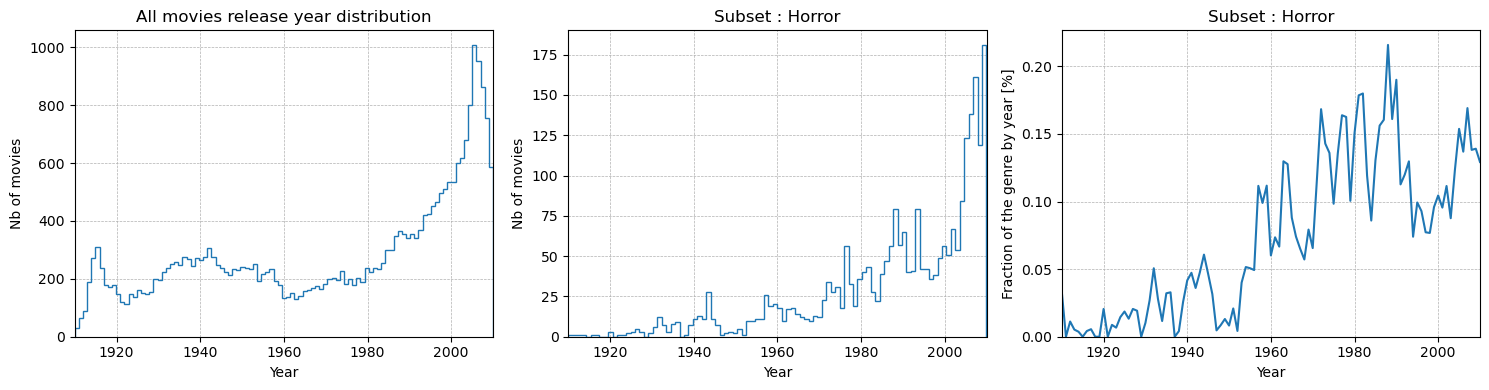

In [7]:
# VISUALIZE SUBSET i
i = find_subset(subsets, 'Horror')
viz_subset(i, subsets, movies)

### c) Trend automatic detection

In [8]:
QUALITY = 0.2
trends = get_trends(movies, subsets, QUALITY)

print('Nb of trends: {}'.format(len(trends)))
print('Trend detection for 5 first subsets:')
display(trends[:5])

Nb of trends: 244
Trend detection for 5 first subsets:


[('Absurdism', [1977, 1995], [1965, 1990]),
 ('Action', [1974], [1967]),
 ('Action Comedy', [], []),
 ('Action Thrillers', [1975, 1995], [1967, 1987]),
 ('Action/Adventure', [1973], [1966])]

======== Subset Animation ========
Peaks: 		  [1937, 1955, 2006]
Inflexion points: [1928, 1949, 1997]
Quality of peaks: [0.8944550792731196, 0.10797647002213683, 0.2703500979062737]


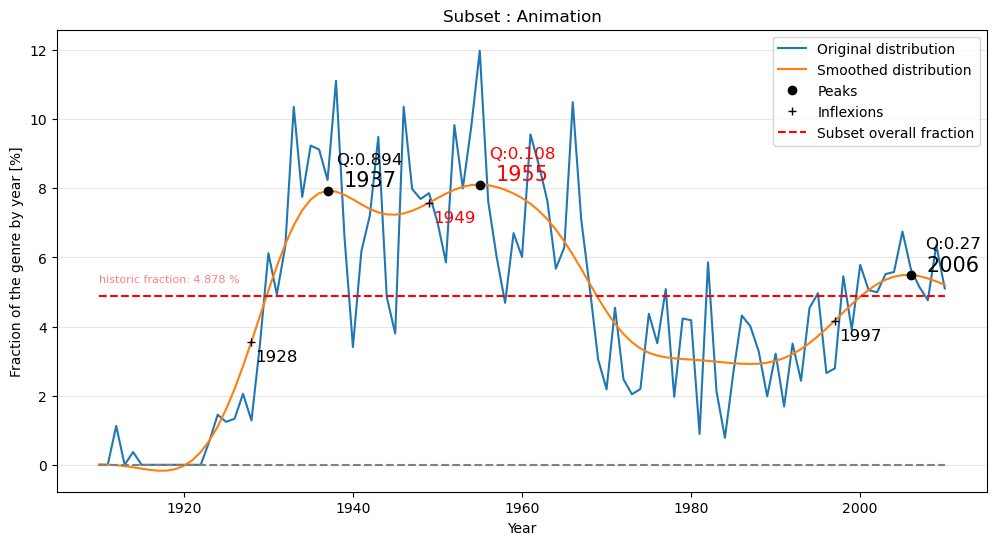

In [9]:
# Visualize trend detection for subset i
i = find_subset(subsets, 'Animation')

print('======== Subset {} ========'.format(subsets[i][0]))
print('Peaks: \t\t  {}'.format(get_peaks(movies, subsets, i)[0]))
print('Inflexion points: {}'.format(get_peaks(movies, subsets, i)[1]))
print('Quality of peaks: {}'.format(get_peaks(movies, subsets, i)[2]))

fig = viz_peaks(movies, subsets, i)

#### c.*) Save all trends visualizations as images

In [10]:
# Run this cell to download all trend plots (6min)
# get_all_viz(movies, subsets)

### d) Construction of potential pivotal movie sets 
 

In [11]:
candidates = get_candidates(subsets, trends)
print('Nb of sets of candidates: {}'.format(len(candidates)))

Nb of sets of candidates: 387


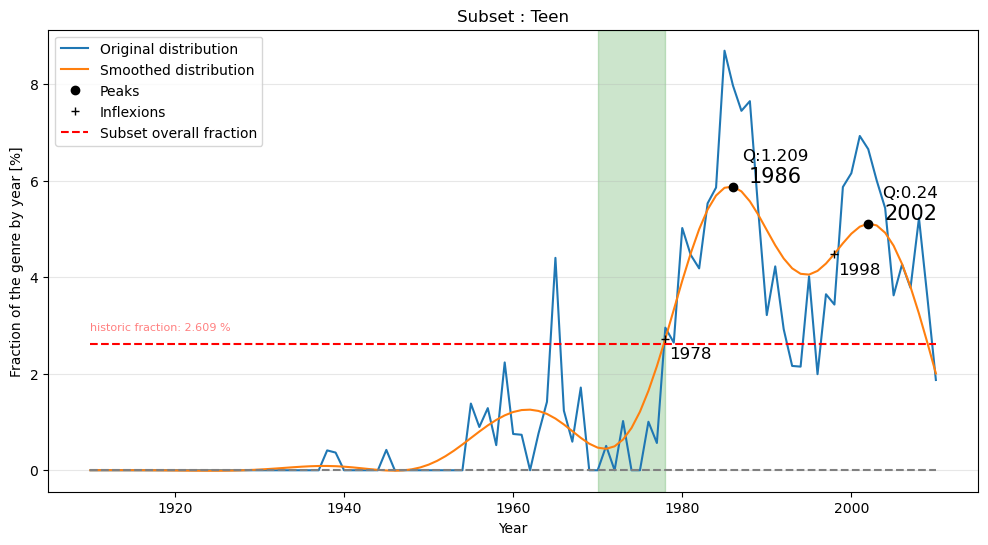

Candidates of pivotal of genre Teen, for trend peak in 1986 and trend inflexion in 1978
Nb of candidates: 12


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
27655,2083964,/m/06l2g2,Let's Scare Jessica to Death,1971,NaN,88.0,[English Language],[USA],"[Thriller, Horror, Supernatural, Psychological..."
6041,68124,/m/0hv8w,American Graffiti,1973,140000000.0,108.0,[English Language],[USA],"[Ensemble Film, Americana, Comedy-drama, Teen,..."
63041,13966551,/m/03cpmcm,Jeremy,1973,NaN,84.0,[English Language],[USA],"[Romance Film, Drama, Teen]"
27724,4220213,/m/0bqn_n,Massacre at Central High,1976,NaN,87.0,[English Language],[USA],"[Crime Fiction, Thriller, Horror, Drama, Polit..."
43730,11437850,/m/02rckkx,Dawn: Portrait of a Teenage Runaway,1976,NaN,100.0,[English Language],[USA],"[Drama, Teen]"
3591,14445050,/m/03d3rh8,Fraternity Row,1977,NaN,105.0,[English Language],[USA],"[Drama, Teen, Docudrama]"
186,336846,/m/01xlqd,Grease,1978,394589888.0,225.0,[English Language],[USA],"[Romantic comedy, LGBT, Musical, Comedy, Roman..."
7305,2996768,/m/08jjwb,Jennifer,1978,NaN,90.0,[English Language],[USA],"[Thriller, Horror, Indie, Teen]"
11524,20179415,/m/0m3gy,Halloween,1978,70000000.0,91.0,[English Language],[USA],"[Thriller, Horror, Indie, Cult, Slasher, Teen]"
30248,3069423,/m/08pb5v,Corvette Summer,1978,NaN,105.0,[English Language],[USA],"[Romantic comedy, Adventure, Screwball comedy,..."


In [12]:
show_candidates(movies, subsets, candidates, 'Teen', peak='first')

## 2) Metric assessment for Pivotal Movies identification

Identifying the pivotal movie, or the one that starts a trend, involves a combination of qualitative and quantitative analysis. Here are considerations and steps to help define the chosen pivotal movie within a specific genre:

 - **Box-office Revenue :**
    Analyze the box-office performance of candidate movies within the subset. The pivotal movie often exhibits exceptional financial success, indicating a strong audience demand for the particular genre or theme. We need then to look for movies that surpassed industry expectations in terms of revenue. Also comparing the box-office performance of candidate movies to industry standards and consider their impact on subsequent films' budgeting and revenue expectations.

- **Reviews :**
   Critical reception is a key indicator of a movie's impact and lasting influence. The pivotal movie should have received positive reviews from both critics and audiences, showcasing its quality and appeal. To this aims we incorporate a new dataset that includes review. These review will be a measuremnent of how good a movie is . This metric is fundamental to identify the pivotal movie : if a film is considered as bad there is no chance that it influence the cinema industry and creating a trend.

- **Awards :**
Another measure for assessing influence is the recognition garnered through awards. Industry accolades serve as a validation of a movie's cultural and artistic significance. The receipt of awards signifies not only the excellence of the film but also its potential to set a standard worth emulating. It provides more precise insights into why the film is esteemed. Noteworthy awards include prestigious honors like the Oscars. In our analysis, we have opted to incorporate a dataset that encompasses these awards and their respective categories.

- **Plot Similarity:**
  This metric serves as an assessment of the extent to which a film influences others within the genre during trends. The concept is as follows: if the plot of a potential pivotal film closely resembles those observed in subsequent trend films when compared to other movies in the candidate subset, it indicates the film's influence on plot development. This similarity suggests that other films intentionally emulated the storyline, signifying the impactful nature of the pivotal film.



All these metrics will be exploited to select the pivotal film among the candidate subset. But to use it we need to properly define function which calculate from available data or simply add missing data from other dataset.


## Further cleaning and data gathering

In [13]:
# Start with the pre-merge df of Milestone 2:

display(movies.sample(5))
display(movies.shape)
display(movies.info())
generate_missing_info(movies)

,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
43874,14935243,/m/03h28d0,The Crow,1919,NaN,20.0,"[Silent film, English Language]",[USA],"[Short Film, Silent film, Western, Black-and-w..."
48910,29450146,/m/0ds9cy5,Mickey's Minstrels,1934,NaN,18.0,[English Language],[USA],[Short Film]
41549,1332901,/m/04th45,Hollow Man,2000,190213455.0,119.0,[English Language],"[USA, Germany]","[Thriller, Science Fiction, Horror, Sci-Fi Hor..."
7158,16306760,/m/047vr7_,Smuggler's Cove,1948,NaN,66.0,[English Language],[USA],"[Crime Fiction, Comedy film]"
17824,22049867,/m/05p5m_x,Hello Down There,1969,NaN,88.0,[English Language],[USA],"[Musical, Comedy]"


(28821, 9)

<class 'pandas.core.frame.DataFrame'>
Index: 28821 entries, 0 to 74827
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_wiki      28821 non-null  int64  
 1   id_freebase  28821 non-null  object 
 2   name         28821 non-null  object 
 3   year         28821 non-null  int32  
 4   revenue      6466 non-null   float64
 5   runtime      25712 non-null  float64
 6   lang         28821 non-null  object 
 7   countries    28821 non-null  object 
 8   genres       28821 non-null  object 
dtypes: float64(2), int32(1), int64(1), object(5)
memory usage: 2.1+ MB


None

,Missing Data (%)
Column,
id_wiki,0.00
id_freebase,0.00
name,0.00
year,0.00
revenue,77.56
runtime,10.79
lang,0.00
countries,0.00
genres,0.00


### Cleaning big IMDB dataset

In [14]:
# Loading big IMDb dataset
IMDB_PATH = '/imdb_ratings_all_time/movies_imdb.csv'

imdb_vanilla = pd.read_csv(DATA_PATH+IMDB_PATH, usecols=['id', 'name', 'year', 'rating', 'duration', 'votes', 'gross_income'], low_memory=False)

display(imdb_vanilla.sample(5))
display(imdb_vanilla.shape)
display(imdb_vanilla.info())
display(imdb_vanilla.isnull().sum())
display(imdb_vanilla[imdb_vanilla['gross_income']!='0'].sample(5))

,id,name,year,rating,duration,votes,gross_income
2369704,tt13183200,It Could Be You,(1956– ),11.0,0 min,0,0
228355,tt8507686,Watering the Flowers,(2017),11.0,0 min,0,0
2213002,tt15435024,Protibimbo,(2020– ),11.0,0 min,0,0
1972280,tt2976662,The New Adventures of Nanoboy,(2008–2013),11.0,23 min,0,0
1013206,tt1202150,Beauty and the Beast,(1983 TV Movie),7.8,60 min,16,0


(2590932, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2590932 entries, 0 to 2590931
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   name          object 
 2   year          object 
 3   rating        float64
 4   duration      object 
 5   votes         object 
 6   gross_income  object 
dtypes: float64(1), object(6)
memory usage: 138.4+ MB


None

id              0
name            4
year            0
rating          0
duration        0
votes           0
gross_income    0
dtype: int64

,id,name,year,rating,duration,votes,gross_income
4481,tt9426186,Revenger,(2018),5.7,101 min,"4,302","676,167"
8629,tt2279853,Guess How Much I Love You: The Adventures of L...,(2012– ),8.0,11 min,78,"6,971,777"
1931555,tt3760218,Roar,(2014),7.2,14 min,9,"106,353"
1467734,tt0096149,Space Mutiny,(1988),2.0,91 min,"7,107","21,671,241"
1318528,tt0230025,Bartleby,(2001),6.4,83 min,2067,"148,479"


In [15]:
imdb = imdb_vanilla.copy(deep=True)

# Let's get rid of the missing movie names
imdb = imdb_vanilla.loc[~imdb_vanilla.name.isnull()]

# Cleaning the year column: removing some characters and extracting starting year only
imdb = imdb[~imdb['year'].astype(str).str.contains('-|–')]
imdb.loc[:, 'year'] = imdb['year'].str.extract(r'(\d+)', expand=False)
imdb['year'] = imdb['year'].replace('', np.nan)
imdb['year'] = pd.to_numeric(imdb['year'], errors='coerce')
imdb.loc[:, 'year'] = imdb['year'].astype('Int64', errors='ignore')

# Dataframe is huge, and we do not care about movies post-2017: let's reduce it a bit
imdb = imdb[imdb['year'] <= 2017].reset_index(drop=True)

# From gross income, remove undesired characters and turn to float:
imdb.loc[:, 'gross_income'] = imdb['gross_income'].apply(lambda x: clean_gross_income(x))
imdb['gross_income'] = pd.to_numeric(imdb['gross_income'], errors='coerce')
imdb.loc[:, 'gross_income'] = imdb['gross_income'].replace(0, np.nan)

# From votes, remove undesired characters and turn to float:
imdb.loc[:, 'votes'] = imdb['votes'].str.replace(',', '').astype(float)
imdb.loc[:, 'votes'] = imdb['votes'].replace(0, np.nan)
imdb.loc[pd.isna(imdb['votes']), 'rating'] = np.nan
imdb = imdb[imdb['rating'] <= 10]

# Extract number from duration:
imdb.loc[:, 'duration'] = imdb['duration'].str.extract(r'(\d+)', expand=False)
imdb.loc[:,'duration'] = imdb['duration'].astype(float)
imdb.loc[:, 'duration'] = imdb['duration'].replace(0, np.nan)
imdb['duration'] = pd.to_numeric(imdb['duration'], errors='coerce')  

# Year and duration are elements used to detect and fuse duplicates: need them clean
imdb = imdb.dropna(subset=['year', 'duration'])

# If both votes and gross_income are unknown, then the row is of no use
imdb = imdb.dropna(subset=['votes', 'gross_income'], how='all').reset_index(drop=True)

display(imdb[~(imdb['gross_income'].isna())!=0].sample(5))
display(imdb.shape)
display(imdb.info())
generate_missing_info(imdb)

,id,name,year,rating,duration,votes,gross_income
181353,tt0037522,Back to Bataan,1945,6.6,95.0,4040.0,1316495.0
58393,tt4450716,Deux,2015,5.5,89.0,53.0,13592.0
174669,tt3707104,Mine,2016,5.9,106.0,17521.0,28142535.0
162128,tt0020359,Salute,1929,5.3,84.0,211.0,267265.0
3084,tt0136646,The Last Don II,1998,6.8,240.0,1096.0,111000.0


(214143, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214143 entries, 0 to 214142
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            214143 non-null  object 
 1   name          214143 non-null  object 
 2   year          214143 non-null  Int64  
 3   rating        214143 non-null  float64
 4   duration      214143 non-null  float64
 5   votes         214143 non-null  object 
 6   gross_income  27935 non-null   float64
dtypes: Int64(1), float64(3), object(3)
memory usage: 11.6+ MB


None

,Missing Data (%)
Column,
id,0.00
name,0.00
year,0.00
rating,0.00
duration,0.00
votes,0.00
gross_income,86.95


In [16]:
# Are there any doublons ?
display(check_doublons(imdb, col_check=['name'], year='year', runtime='duration'))

# Example of a doublon 
display(imdb[(imdb['name']=='Unconditional') & (imdb['year']==2012)]) 

Rows with real duplicates: 
                              name  year  duration
3134                 Unconditional  2012      92.0
4210                   Blood Money  2012     109.0
12047   The Game Ain't 4 Everybody  2009     105.0
13546                      Misfits  2015      20.0
14199          Trouble in Paradise  1989     100.0
...                            ...   ...       ...
214138                   Game Face  2017      42.0
214139                   Game Face  2017      42.0
214140                   Game Face  2017      42.0
214141                   Game Face  2017      42.0
214142                   Game Face  2017      42.0

[10243 rows x 3 columns]
--------------------------------------------------------------------------------


None

,id,name,year,rating,duration,votes,gross_income
3134,tt1758610,Unconditional,2012,7.0,92.0,4800.0,1005800.0
199175,tt1967651,Unconditional,2012,6.5,92.0,741.0,NaN


In [17]:
# Need to fuse the duplicates
imdb_clean = imdb.copy(deep=True)

imdb_clean = fuse_duplicates_imdb(imdb_clean)
imdb_clean = calculate_weighted_average(imdb_clean, 'name', 'rating', 'votes')

# Merge successful ?
display(imdb_clean[(imdb_clean['name']=='Unconditional') & (imdb_clean['year']==2012)]) 
display(check_doublons(imdb_clean, col_check=['name'], year='year', runtime='duration'))
# Yes !

display(imdb_clean.sample(5))
display(imdb_clean.shape)
display(imdb_clean.info())

,id,name,year,rating,duration,votes,gross_income
3134,tt1758610,Unconditional,2012,6.9,92.0,5541.0,1005800.0


No duplicates
--------------------------------------------------------------------------------


None

,id,name,year,rating,duration,votes,gross_income
75771,tt0027447,Cielito lindo,1936,6.8,80.0,17.0,NaN
168905,tt0180654,Downtime,1995,5.5,65.0,168.0,NaN
205083,tt3636938,Avalanche,2014,6.3,16.0,17.0,NaN
144126,tt0435774,When Tyrants Kiss,2004,6.9,93.0,19.0,NaN
150844,tt0302961,Rapiña,1975,7.5,114.0,114.0,398000.0


(205729, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 205729 entries, 0 to 214136
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            205729 non-null  object 
 1   name          205729 non-null  object 
 2   year          205729 non-null  Int64  
 3   rating        205729 non-null  float64
 4   duration      205729 non-null  float64
 5   votes         205729 non-null  float64
 6   gross_income  27934 non-null   float64
dtypes: Int64(1), float64(4), object(2)
memory usage: 12.8+ MB


None

### Original name map

In [18]:
NAME_MAP_PATH = '/imdb_ratings_all_time/imdb_title_map.tsv'

name_map_vanilla = pd.read_csv(DATA_PATH+NAME_MAP_PATH, sep='\t', usecols=['tconst', 'primaryTitle', 'originalTitle', 'startYear', 'runtimeMinutes']).rename(columns={'originalTitle': 'name',
                                                                                                                                                        'startYear': 'year',
                                                                                                                                                        'runtimeMinutes': 'duration'})

display(name_map_vanilla.sample(5))
display(name_map_vanilla.shape)
display(name_map_vanilla.info())

,tconst,primaryTitle,name,year,duration
3852372,tt15288208,Episode #5.55,Episode #5.55,\N,\N
5897527,tt2319670,Supergirl,Supergirl,2012,20
2458683,tt12713300,Episodio 418,Episodio 418,2019,\N
219946,tt0229684,Roosevelt's Rough Riders Embarking for Santiago,Roosevelt's Rough Riders Embarking for Santiago,1898,\N
2711436,tt13181788,De Glemte Kæmper Del 2,De Glemte Kæmper Del 2,2021,\N


(9387091, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9387091 entries, 0 to 9387090
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   tconst        object
 1   primaryTitle  object
 2   name          object
 3   year          object
 4   duration      object
dtypes: object(5)
memory usage: 358.1+ MB


None

In [19]:
# This dataframe is the key to overcome the "Star Wars" problem
# (ie: nomenclature changes for same movie across dataframes)

display(name_map_vanilla[name_map_vanilla['name']=='Star Wars'].head(1))
display(imdb_clean[imdb_clean['name']=='Star Wars'])
display(movies[movies['name'].str.contains('Star Wars Episode VI: Return of the Jedi')])

,tconst,primaryTitle,name,year,duration
75141,tt0076759,Star Wars: Episode IV - A New Hope,Star Wars,1977,121


,id,name,year,rating,duration,votes,gross_income
147390,tt0076759,Star Wars,1977,8.6,121.0,1332366.0,322740140.0


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
14376,50744,/m/0ddjy,Star Wars Episode VI: Return of the Jedi,1983,475106177.0,135.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."


In [20]:
# Extract duration in minutes
name_map_vanilla['duration'] = name_map_vanilla['duration'].str.extract('(\d+\.\d+|\d+)').astype(float)
# If there are non-numeric values, replace them with np.nan
name_map_vanilla['duration'] = name_map_vanilla['duration'].replace('', np.nan)

# Extract year
name_map_vanilla['year'] = name_map_vanilla['year'].str.extract('(\d+)').astype(float)
# If there are non-numeric values, replace them with np.nan
name_map_vanilla['year'] = name_map_vanilla['year'].replace('', np.nan)
name_map_vanilla.loc[:, 'year'] = name_map_vanilla['year'].astype('Int64', errors='ignore')

# Get rid of missing data in duration and year
name_map = name_map_vanilla.copy(deep=True)
name_map = name_map_vanilla.dropna(subset=['duration', 'year']).reset_index(drop=True)

display(name_map.sample(5))
display(name_map.info())
generate_missing_info(name_map)


,tconst,primaryTitle,name,year,duration
2404359,tt5971582,C-19,C-19,2017,42.0
1919738,tt2937178,Go Team Go,Go Team Go,2013,21.0
844917,tt1241638,Tatakeyo saraba hirakaren,Tatakeyo saraba hirakaren,2008,24.0
1892640,tt2892946,Girlish Petting: Part 2,Girlish Petting: Part 2,2005,8.0
1628978,tt2320135,Zoku Tokyo nagaremono - Umi wa makka na koi no...,Zoku Tokyo nagaremono - Umi wa makka na koi no...,1966,73.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644199 entries, 0 to 2644198
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   tconst        object 
 1   primaryTitle  object 
 2   name          object 
 3   year          Int64  
 4   duration      float64
dtypes: Int64(1), float64(1), object(3)
memory usage: 103.4+ MB


None

,Missing Data (%)
Column,
tconst,0.0
primaryTitle,0.0
name,0.0
year,0.0
duration,0.0


In [21]:
# Are there any doublons ?
display(check_doublons(name_map, col_check=['name'], year='year', runtime='duration'))

# If that's the case let's drop the doublons
name_map_clean = drop_duplicates(name_map, col_check=['name', 'year', 'duration'])

display(check_doublons(name_map_clean, col_check=['name'], year='year', runtime='duration'))
display(name_map_clean.info())

Rows with real duplicates: 
                           name  year  duration
103      The Kiss in the Tunnel  1899       1.0
1262      Bread Upon the Waters  1913      11.0
1334          The Doctor's Duty  1913      11.0
1385                 Flood Tide  1913      11.0
1480                  The Idler  1914      11.0
...                         ...   ...       ...
2644083           Episode #1.10  2017      55.0
2644084            Episode #1.3  2017      55.0
2644129                  Broken  2017       4.0
2644167               Avsnitt 3  2017      44.0
2644168               Avsnitt 4  2017      45.0

[178245 rows x 3 columns]
--------------------------------------------------------------------------------


None

No duplicates
--------------------------------------------------------------------------------


None

<class 'pandas.core.frame.DataFrame'>
Index: 2526746 entries, 0 to 2644198
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   tconst        object 
 1   primaryTitle  object 
 2   name          object 
 3   year          Int64  
 4   duration      float64
dtypes: Int64(1), float64(1), object(3)
memory usage: 118.1+ MB


None

### IMDB MERGE

In [22]:
# Merging imdb_clean and name_map_clean to obtain the final IMDb dataframe
imdb_final = pd.merge(name_map_clean, imdb_clean, on=['name', 'year', 'duration'], how='right').drop(columns={'tconst', 'id'}).rename(columns={'primaryTitle': 'alt_name',
                                                                                                                                                'duration': 'runtime', 
                                                                                                                                                'gross_income': 'revenue'})

display(imdb_final.sample(5))
display(imdb_final.shape)
display(imdb_final.info())
generate_missing_info(imdb_final)

# The "Star Wars" problem is taken care of
display(imdb_final[imdb_final['name']=='Star Wars'])

,alt_name,name,year,runtime,rating,votes,revenue
150354,Sudba rezidenta,Sudba rezidenta,1970,157.0,7.1,178.0,NaN
200273,Cathy,Cathy,2017,11.0,8.5,7.0,NaN
104428,NaN,Take That: Let in the Sun,2015,4.0,5.7,9.0,NaN
105944,NaN,Lensman,1984,107.0,6.4,678.0,NaN
199113,Cain Rose Up,Cain Rose Up,2017,8.0,5.9,26.0,NaN


(205729, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205729 entries, 0 to 205728
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   alt_name  158007 non-null  object 
 1   name      205729 non-null  object 
 2   year      205729 non-null  Int64  
 3   runtime   205729 non-null  float64
 4   rating    205729 non-null  float64
 5   votes     205729 non-null  float64
 6   revenue   27934 non-null   float64
dtypes: Int64(1), float64(4), object(2)
memory usage: 11.2+ MB


None

,alt_name,name,year,runtime,rating,votes,revenue
141635,Star Wars: Episode IV - A New Hope,Star Wars,1977,121.0,8.6,1332366.0,322740140.0


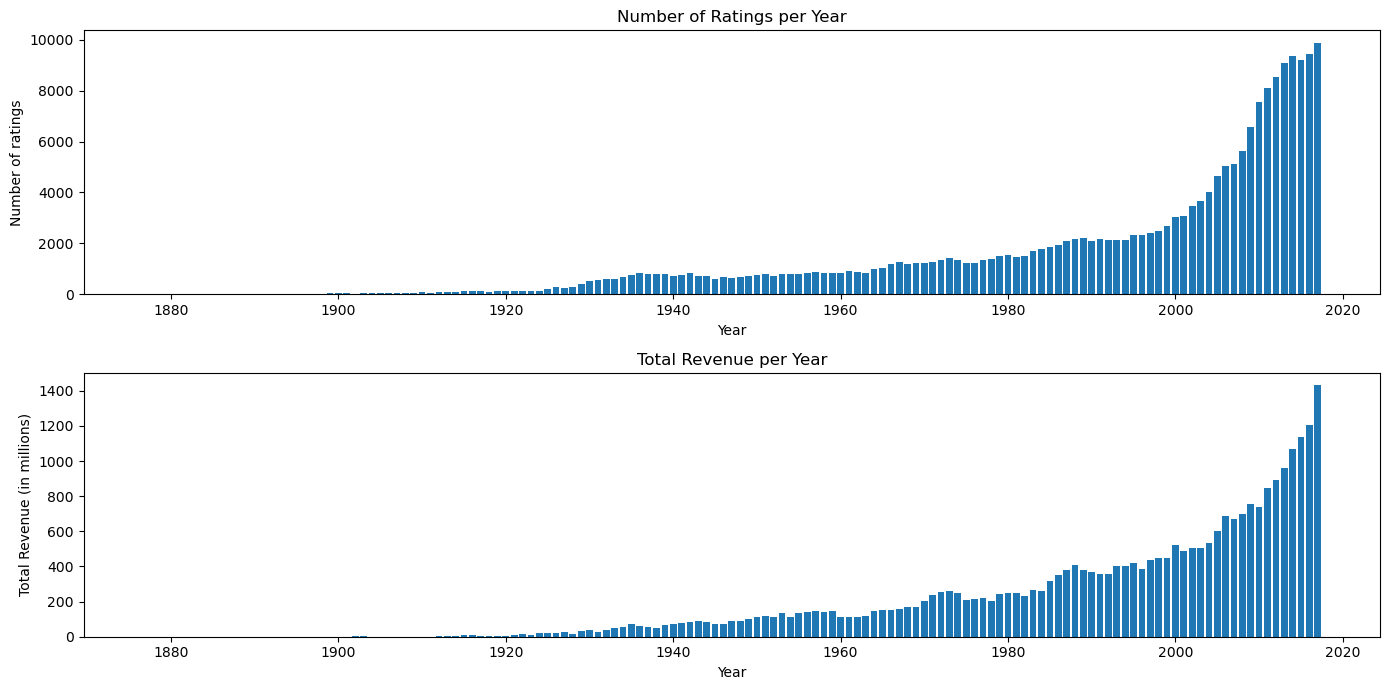

In [23]:
# Let's check the yearly distribution of ratings and revenues in the imdb_final dataframe
revenue_per_year_imdb = imdb_final.groupby('year')['revenue'].count().reset_index()
reviews_count_per_year_imdb = imdb_final.groupby('year')['rating'].count().reset_index()

fig = plt.figure(figsize=(14, 7))

# Plot for number of ratings per year
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.bar(reviews_count_per_year_imdb['year'], reviews_count_per_year_imdb['rating'])
plt.xlabel('Year')
plt.ylabel('Number of ratings')
plt.title('Number of Ratings per Year')

# Plot for revenue per year
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.bar(revenue_per_year_imdb['year'], revenue_per_year_imdb['revenue'])
plt.xlabel('Year')
plt.ylabel('Total Revenue (in millions)')
plt.title('Total Revenue per Year')

plt.tight_layout()
plt.show()

In [24]:
# To make it ready for future merges: clean the names to get rid of some characters and trailing white spaces
imdb_final['alt_name'] = imdb_final['alt_name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
imdb_final['alt_name'] = imdb_final['alt_name'].str.replace('\s+', ' ', regex=True).str.strip()
imdb_final['name'] = imdb_final['name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
imdb_final['name'] = imdb_final['name'].str.replace('\s+', ' ', regex=True).str.strip()

display(imdb_final[imdb_final['name']=='Star Wars'])

,alt_name,name,year,runtime,rating,votes,revenue
141635,Star Wars Episode IV A New Hope,Star Wars,1977,121.0,8.6,1332366.0,322740140.0


### IMDB_FINAL & MOVIELENS MERGE

In [25]:
# Loading the cleaned movie_lens dataframe from Milestone 2
movies_lens = movies_lens.rename(columns={'review': 'rating', 'nbr_review': 'votes'})

# To make it ready for future merges: clean the names to get rid of some characters and trailing white spaces

movies_lens['name'] = movies_lens['name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
movies_lens['name'] = movies_lens['name'].str.replace('\s+', ' ', regex=True).str.strip()

display(movies_lens.sample(5))
display(movies_lens.shape)
display(movies_lens.info())

,revenue,runtime,name,rating,votes,year
1443,95461682.0,97.0,Arthur,6.5,125.0,1981
4522,31649.0,98.0,Meet Monica Velour,5.5,12.0,2010
4756,149295601.0,121.0,Lone Survivor,7.4,1549.0,2013
2182,28023563.0,75.0,Pokémon 4Ever Celebi Voice of the Forest,5.7,82.0,2001
4069,60251371.0,123.0,Secretariat,6.8,103.0,2010


(5619, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5619 entries, 0 to 5618
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   revenue  5619 non-null   float64
 1   runtime  5619 non-null   float64
 2   name     5619 non-null   object 
 3   rating   5619 non-null   float64
 4   votes    5619 non-null   float64
 5   year     5619 non-null   int32  
dtypes: float64(4), int32(1), object(1)
memory usage: 241.6+ KB


None

In [26]:
# Merging imdb_final and movies_lens to complete annex data
annex = pd.merge(movies_lens, imdb_final, on=['name', 'year', 'runtime'], how='right')

display(annex.sample(5))
display(annex.shape)
display(annex.info())
generate_missing_info(annex)

,revenue_x,runtime,name,rating_x,votes_x,year,alt_name,rating_y,votes_y,revenue_y
6254,NaN,105.0,Sikander,NaN,NaN,2013,Sikander,7.3,118.0,93817.0
63767,NaN,70.0,Street Paper,NaN,NaN,2012,Street Paper,6.8,6.0,NaN
181743,NaN,160.0,Refugee,NaN,NaN,2006,Refugee,5.8,95.0,NaN
126301,NaN,9.0,Yankale,NaN,NaN,1996,Yankale,7.5,13.0,NaN
22131,NaN,110.0,Breathful,NaN,NaN,2007,Breathful,3.0,410.0,NaN


(205729, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205729 entries, 0 to 205728
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   revenue_x  3111 non-null    float64
 1   runtime    205729 non-null  float64
 2   name       205729 non-null  object 
 3   rating_x   3111 non-null    float64
 4   votes_x    3111 non-null    float64
 5   year       205729 non-null  Int64  
 6   alt_name   205729 non-null  object 
 7   rating_y   205729 non-null  float64
 8   votes_y    205729 non-null  float64
 9   revenue_y  27934 non-null   float64
dtypes: Int64(1), float64(7), object(2)
memory usage: 15.9+ MB


None

,Missing Data (%)
Column,
revenue_x,98.49
runtime,0.00
name,0.00
rating_x,98.49
votes_x,98.49
year,0.00
alt_name,0.00
rating_y,0.00
votes_y,0.00


In [27]:
annex_merge = annex.copy(deep=True)

# Fuse the revenue columns
annex_merge['revenue'] = annex_merge.apply(lambda row: fuse_columns_v2(row[f'revenue_x'], row[f'revenue_y']), axis=1)
annex_merge['revenue'] = pd.to_numeric(annex_merge['revenue'], errors='coerce')
annex_merge = annex_merge.drop(['revenue_x', 'revenue_y'], axis=1)

# Fuse the rating and votes columns
annex_merge = fuse_scores_v2(annex_merge, score_col1='rating_x', score_col2='rating_y', votes_col1='votes_x', votes_col2='votes_y', score_col='rating', votes_col='votes')

# Adressing alt_name nan issue
annex_merge['alt_name'] = annex_merge['alt_name'].replace('nan', None)
annex_merge['alt_name'].fillna(annex_merge['name'], inplace=True)

# Are there any doublons ?
display(check_doublons(annex_merge, ['alt_name'], 'year', 'runtime'))
display(check_doublons(annex_merge, ['name'], 'year', 'runtime'))

# If so let's fuse them to create a merge ready annex:
annex_merge = fuse_duplicates_v2(df=annex_merge, col_check=['name', 'alt_name'], year='year', runtime='runtime', col_null=['revenue'], col_score='rating', col_weight='votes')

display(check_doublons(annex_merge, ['alt_name'], 'year', 'runtime'))
display(check_doublons(annex_merge, ['name'], 'year', 'runtime'))

display(annex_merge.sample(5))
display(annex_merge.shape)
display(annex_merge.info())

Rows with real duplicates: 
                          alt_name  year  runtime
410                  The Defenders  2017     50.0
611                       The Firm  2012     60.0
703           Strong Girl Bongsoon  2017     67.0
778                       Paranoid  2016     45.0
787                American Gothic  2016     40.0
...                            ...   ...      ...
205569                       Lucan  2013     63.0
205577        The Putin Interviews  2017     58.0
205720       Expedition Impossible  2011     60.0
205722  The Voice Kids (Australia)  2014     90.0
205725      MythBusters The Search  2017     42.0

[890 rows x 3 columns]
--------------------------------------------------------------------------------


None

Rows with real duplicates: 
                              name  year  runtime
410                  The Defenders  2017     50.0
611                       The Firm  2012     60.0
703           Strong Girl Bongsoon  2017     67.0
778                       Paranoid  2016     45.0
787                American Gothic  2016     40.0
...                            ...   ...      ...
205569                       Lucan  2013     63.0
205577        The Putin Interviews  2017     58.0
205720       Expedition Impossible  2011     60.0
205722  The Voice Kids (Australia)  2014     90.0
205725      MythBusters The Search  2017     42.0

[910 rows x 3 columns]
--------------------------------------------------------------------------------


None

Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
No duplicates
--------------------------------------------------------------------------------


None

No duplicates
--------------------------------------------------------------------------------


None

,runtime,name,year,alt_name,revenue,rating,votes
174616,110.0,A Woman at War,1991,A Woman at War,NaN,6.1,147.0
35544,75.0,The Alien Within,1995,The Alien Within,NaN,4.1,308.0
189378,13.0,The Root of All Evil,2013,The Root of All Evil,NaN,8.2,29.0
152083,100.0,SOS Gletscherpilot,1959,SOS Glacier Pilot,NaN,6.9,29.0
3164,102.0,On the Doll,2007,On the Doll,NaN,5.3,1542.0


(205269, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205269 entries, 0 to 205268
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   runtime   205269 non-null  float64
 1   name      205269 non-null  object 
 2   year      205269 non-null  Int64  
 3   alt_name  205269 non-null  object 
 4   revenue   27972 non-null   float64
 5   rating    205269 non-null  float64
 6   votes     205269 non-null  float64
dtypes: Int64(1), float64(4), object(2)
memory usage: 11.2+ MB


None

### ANNEX_MERGE & MOVIES_MERGE MERGE

In [28]:
# To make movies ready for future merges: clean the names to get rid of some characters and trailing white spaces
movies_merge = movies.copy(deep=True).reset_index(drop=True)
movies_merge['name'] = movies_merge['name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
movies_merge['name'] = movies_merge['name'].str.replace('\s+', ' ', regex=True).str.strip()

display(movies_merge.sample(5))
display(movies_merge.shape)
display(movies_merge.info())
generate_missing_info(movies_merge)

,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
1744,8850351,/m/027lz88,Evil Bong,2006,NaN,80.0,[English Language],[USA],"[Horror, Cult, Comedy, Black comedy, Stoner fi..."
6729,16792210,/m/07s43gs,Obsessed,2009,73830340.0,108.0,[English Language],[USA],"[Thriller, Erotic thriller, Drama, Suspense]"
10652,21509421,/m/05h4s5n,Immediate Family,1989,5932613.0,99.0,[English Language],[USA],"[Family Drama, Drama]"
7139,23355259,/m/06w4tm0,Law and Disorder,1974,NaN,99.0,[English Language],[USA],"[Crime Fiction, Drama, Comedy]"
8977,23690998,/m/06zss4n,The Carson City Kid,1940,NaN,54.0,[English Language],[USA],"[Action/Adventure, Western]"


(28821, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28821 entries, 0 to 28820
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_wiki      28821 non-null  int64  
 1   id_freebase  28821 non-null  object 
 2   name         28821 non-null  object 
 3   year         28821 non-null  int32  
 4   revenue      6466 non-null   float64
 5   runtime      25712 non-null  float64
 6   lang         28821 non-null  object 
 7   countries    28821 non-null  object 
 8   genres       28821 non-null  object 
dtypes: float64(2), int32(1), int64(1), object(5)
memory usage: 1.9+ MB


None

,Missing Data (%)
Column,
id_wiki,0.00
id_freebase,0.00
name,0.00
year,0.00
revenue,77.56
runtime,10.79
lang,0.00
countries,0.00
genres,0.00


In [29]:
# Let's complete movies_merge with data from annex_merge
movies3_vanilla = pd.merge(annex_merge, movies_merge, left_on=['alt_name', 'year'], right_on=['name', 'year'], how='right')

display(movies3_vanilla.sample(5))
display(movies3_vanilla.shape)
display(movies3_vanilla.info())

,runtime_x,name_x,year,alt_name,revenue_x,rating,votes,id_wiki,id_freebase,name_y,revenue_y,runtime_y,lang,countries,genres
9624,NaN,NaN,1940,NaN,NaN,NaN,NaN,8702770,/m/027fjqp,He Married His Wife,NaN,83.0,[English Language],[USA],"[Romance Film, Comedy, Black-and-white]"
5870,NaN,NaN,2008,NaN,NaN,NaN,NaN,32799797,/m/0h3s3ks,Inconceivable,NaN,105.0,[English Language],"[USA, France, Canada, United Kingdom]","[Drama, Comedy]"
12896,NaN,NaN,1996,NaN,NaN,NaN,NaN,4186717,/m/0bnx59,Love Is All There Is,32925.0,105.0,[English Language],[USA],"[Romantic comedy, Romance Film, Indie, Comedy]"
6353,87.0,Meet Me After the Show,1951,Meet Me After the Show,2606000.0,6.2,196.0,26206020,/m/0b73kjz,Meet Me After the Show,2000000.0,87.0,[English Language],[USA],"[Musical, Comedy]"
13914,102.0,A Nightingale Sang in Berkeley Square,1979,A Nightingale Sang in Berkeley Square,NaN,5.7,441.0,5080214,/m/0d1t3h,A Nightingale Sang in Berkeley Square,NaN,106.0,[English Language],"[USA, United Kingdom]","[Crime Fiction, Action/Adventure, Heist]"


(29051, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   runtime_x    14650 non-null  float64
 1   name_x       14650 non-null  object 
 2   year         29051 non-null  Int64  
 3   alt_name     14650 non-null  object 
 4   revenue_x    7947 non-null   float64
 5   rating       14650 non-null  float64
 6   votes        14650 non-null  float64
 7   id_wiki      29051 non-null  int64  
 8   id_freebase  29051 non-null  object 
 9   name_y       29051 non-null  object 
 10  revenue_y    6527 non-null   float64
 11  runtime_y    25936 non-null  float64
 12  lang         29051 non-null  object 
 13  countries    29051 non-null  object 
 14  genres       29051 non-null  object 
dtypes: Int64(1), float64(6), int64(1), object(7)
memory usage: 3.4+ MB


None

In [30]:
# Need to clean merged dataframe
movies3 = movies3_vanilla.copy(deep=True)

# For some reason, annex revenue tends to underestimate movies3 revenue
valid_rows = movies3_vanilla.dropna(subset=['revenue_x', 'revenue_y'])
percentage_higher = (valid_rows['revenue_x'] > valid_rows['revenue_y']).mean() * 100
percentage_lower = (valid_rows['revenue_x'] < valid_rows['revenue_y']).mean() * 100
percentage_equal = (valid_rows['revenue_x'] == valid_rows['revenue_y']).mean() * 100

print(f"The percentage of times 'revenue_x' is higher than 'revenue_y' when both are not NaN is: {percentage_higher:.2f}%") 
print(f"The percentage of times 'revenue_x' is lower than 'revenue_y' when both are not NaN is: {percentage_lower:.2f}%") 
print(f"The percentage of times 'revenue_x' is equal to 'revenue_y' when both are not NaN is: {percentage_equal:.2f}%") 

# Let's scale underestimated revenues
scaling_factor = (movies3[movies3['revenue_x'] < movies3['revenue_y']]['revenue_y'] / 
                  movies3[movies3['revenue_x'] < movies3['revenue_y']]['revenue_x']).median()
print('The scaling factor is: ', scaling_factor)

movies3.loc[movies3['revenue_x'] < movies3['revenue_y'], 'revenue_x'] = (
    movies3[movies3['revenue_x'] < movies3['revenue_y']]['revenue_x'] * scaling_factor
).apply('{:e}'.format)
movies3['revenue_x'] = pd.to_numeric(movies3['revenue_x'], errors='coerce')

display(movies3.info())

The percentage of times 'revenue_x' is higher than 'revenue_y' when both are not NaN is: 12.93%
The percentage of times 'revenue_x' is lower than 'revenue_y' when both are not NaN is: 62.20%
The percentage of times 'revenue_x' is equal to 'revenue_y' when both are not NaN is: 24.87%
The scaling factor is:  1.351464995146241
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   runtime_x    14650 non-null  float64
 1   name_x       14650 non-null  object 
 2   year         29051 non-null  Int64  
 3   alt_name     14650 non-null  object 
 4   revenue_x    7947 non-null   float64
 5   rating       14650 non-null  float64
 6   votes        14650 non-null  float64
 7   id_wiki      29051 non-null  int64  
 8   id_freebase  29051 non-null  object 
 9   name_y       29051 non-null  object 
 10  revenue_y    6527 non-null   float64
 11  runtime_y    2

C:\Users\paulr\AppData\Local\Temp\ipykernel_22448\21779629.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1.516711e+07' '3.100670e+06' '3.927101e+07' ... '3.407814e+05'
 '1.549602e+07' '4.974696e+08']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  movies3.loc[movies3['revenue_x'] < movies3['revenue_y'], 'revenue_x'] = (


None

In [31]:
#Let's fuse revenues
movies3['revenue'] = movies3.apply(lambda row: fuse_columns_v2(row[f'revenue_x'], row[f'revenue_y']), axis=1)
movies3 = movies3.drop(columns=['runtime_x', 'alt_name', 'revenue_x', 'revenue_y'])
movies3 = movies3.rename(columns={'runtime_y': 'runtime', 'name_x': 'alt_name', 'name_y': 'name'})

# Complete missing alt_name
movies3['alt_name'] = movies3['alt_name'].replace('nan', None)
movies3['alt_name'].fillna(movies3['name'], inplace=True)

display(movies3.sample(5))
display(movies3.info())

,alt_name,year,rating,votes,id_wiki,id_freebase,name,runtime,lang,countries,genres,revenue
6240,Pontiac Moon,1994,NaN,NaN,22141846,/m/05p8dwc,Pontiac Moon,106.0,[English Language],[USA],"[Road movie, Period piece, Drama]",<NA>
3221,3 The Dale Earnhardt Story,2004,6.7,1644.0,1154672,/m/04bvrx,3 The Dale Earnhardt Story,92.0,[English Language],[USA],"[Sports, Biography, Drama, Auto racing, Televi...",155158.0
12045,Dizzy Red Riding Hood,1931,NaN,NaN,28207640,/m/0cnygjs,Dizzy Red Riding Hood,6.0,[English Language],[USA],"[Short Film, Animation, Animated cartoon]",<NA>
13348,Escapade in Japan,1957,5.8,478.0,19200935,/m/04lf_tn,Escapade in Japan,93.0,"[Japanese Language, English Language]",[USA],"[Drama, Childhood Drama, Children's/Family]",<NA>
14081,Phantom Punch,2008,5.5,800.0,19031242,/m/04jmbgy,Phantom Punch,104.0,[English Language],[USA],"[Biography, Boxing, Sports, Period piece, Dram...",<NA>


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   alt_name     29051 non-null  object 
 1   year         29051 non-null  Int64  
 2   rating       14650 non-null  float64
 3   votes        14650 non-null  float64
 4   id_wiki      29051 non-null  int64  
 5   id_freebase  29051 non-null  object 
 6   name         29051 non-null  object 
 7   runtime      25936 non-null  float64
 8   lang         29051 non-null  object 
 9   countries    29051 non-null  object 
 10  genres       29051 non-null  object 
 11  revenue      10731 non-null  object 
dtypes: Int64(1), float64(3), int64(1), object(7)
memory usage: 2.7+ MB


None

### Completing MOVIES3 with MOVIESTATS

In [32]:
# Some renowned movies are still missing, so let's incorporate movies_stats dataframe
movies_stats = movies_stats.rename(columns={'review': 'rating', 'nbr_review': 'votes'})
movies_stats['name'] = movies_stats['name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
movies_stats['name'] = movies_stats['name'].str.replace('\s+', ' ', regex=True).str.strip()

display(movies_stats.sample(5))
display(movies_stats.shape)
display(movies_stats.info())

,name,year,rating,votes,countries,revenue,runtime
6688,Minions,2015,6.4,218000.0,United States,1.159445e+09,91.0
2147,Bébé's Kids,1992,5.8,4900.0,United States,8.442162e+06,72.0
4691,Robots,2005,6.3,137000.0,United States,2.625115e+08,91.0
6504,Teenage Mutant Ninja Turtles,2014,5.8,203000.0,United States,4.850048e+08,101.0
2046,My Cousin Vinny,1992,7.6,112000.0,United States,6.408855e+07,120.0


(5377, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 5377 entries, 1 to 7659
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       5377 non-null   object 
 1   year       5377 non-null   int64  
 2   rating     5377 non-null   float64
 3   votes      5377 non-null   float64
 4   countries  5377 non-null   object 
 5   revenue    5377 non-null   float64
 6   runtime    5376 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 336.1+ KB


None

In [33]:
# Completing movies3 with movies_stats to obtain movies3_stats
movies3_stats = pd.merge(movies_stats, movies3, on=['name', 'year'], how='right')

display(movies3_stats.sample(5))
display(movies3_stats.shape)
display(movies3_stats.info())

,name,year,rating_x,votes_x,countries_x,revenue_x,runtime_x,alt_name,rating_y,votes_y,id_wiki,id_freebase,runtime_y,lang,countries_y,genres,revenue_y
27696,The Ballad of Little Jo,1993,NaN,NaN,NaN,NaN,NaN,The Ballad of Little Jo,6.7,1593.0,6288907,/m/0f_kz3,121.0,[English Language],[USA],"[Biography, Indie, Period piece, Action/Advent...",543091.0
12211,Year One,2009,4.9,94000.0,United States,62357900.0,97.0,Year One,NaN,NaN,14097392,/m/03hfzqc,100.0,[English Language],[USA],"[Parody, Buddy film, Adventure, Absurdism, Per...",43337279.0
20502,Beethoven,1992,5.7,68000.0,United States,147214049.0,87.0,Beethoven,NaN,NaN,348994,/m/01z0p2,87.0,[English Language],[USA],"[Family Film, Drama, Comedy]",<NA>
19502,The Sisters,1914,NaN,NaN,NaN,NaN,NaN,The Sisters,NaN,NaN,14840843,/m/03gzsps,20.0,"[Silent film, English Language]",[USA],"[Short Film, Silent film, Drama, Indie, Black-...",<NA>
5461,Saving Silverman,2001,5.9,39000.0,United States,26086706.0,90.0,Saving Silverman,5.8,40717.0,1374201,/m/04xnsh,93.0,"[English Language, Thai Language]","[USA, Australia]","[Crime Fiction, Romantic comedy, Buddy film, S...",26119838.0


(29051, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         29051 non-null  object 
 1   year         29051 non-null  Int64  
 2   rating_x     3829 non-null   float64
 3   votes_x      3829 non-null   float64
 4   countries_x  3829 non-null   object 
 5   revenue_x    3829 non-null   float64
 6   runtime_x    3829 non-null   float64
 7   alt_name     29051 non-null  object 
 8   rating_y     14650 non-null  float64
 9   votes_y      14650 non-null  float64
 10  id_wiki      29051 non-null  int64  
 11  id_freebase  29051 non-null  object 
 12  runtime_y    25936 non-null  float64
 13  lang         29051 non-null  object 
 14  countries_y  29051 non-null  object 
 15  genres       29051 non-null  object 
 16  revenue_y    10731 non-null  object 
dtypes: Int64(1), float64(7), int64(1), object(8)
memory usage: 3.8+ MB


None

In [34]:
# Before fusing them, need to compare revenue_x and revenue_y
valid_rows = movies3_stats.dropna(subset=['revenue_x', 'revenue_y'])
percentage_higher = (valid_rows['revenue_x'] > valid_rows['revenue_y']).mean() * 100
percentage_lower = (valid_rows['revenue_x'] < valid_rows['revenue_y']).mean() * 100
percentage_equal = (valid_rows['revenue_x'] == valid_rows['revenue_y']).mean() * 100

print(f"The percentage of times 'revenue_x' is higher than 'revenue_y' when both are not NaN is: {percentage_higher:.2f}%") 
print(f"The percentage of times 'revenue_x' is lower than 'revenue_y' when both are not NaN is: {percentage_lower:.2f}%") 
print(f"The percentage of times 'revenue_x' is equal to 'revenue_y' when both are not NaN is: {percentage_equal:.2f}%") 
# Moviestats is more evenly distributed so no scaling factor needed 

# Since moviestats source is IMDB too, we don't want to double count the votes: use fuse_scores_stats
movies3_stats = fuse_scores_stats(df=movies3_stats, score_col1='rating_x', score_col2='rating_y', votes_col1='votes_x', votes_col2='votes_y')
movies3_stats['revenue'] = movies3_stats.apply(lambda row: fuse_columns(x=row['revenue_x'], y=row['revenue_y'], column_name='') if pd.isna(row['revenue_y']) 
                                                     else row['revenue_y'], axis=1)

movies3_stats = movies3_stats.drop(columns=['revenue_x', 'revenue_y', 'rating_x','votes_x', 'countries_x', 'runtime_x'])
movies3_stats = movies3_stats.rename(columns={'runtime_y': 'runtime', 'rating_y': 'rating', 'votes_y': 'votes', 'countries_y': 'countries'})

display(movies3_stats.info())

The percentage of times 'revenue_x' is higher than 'revenue_y' when both are not NaN is: 32.94%
The percentage of times 'revenue_x' is lower than 'revenue_y' when both are not NaN is: 28.60%
The percentage of times 'revenue_x' is equal to 'revenue_y' when both are not NaN is: 38.46%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         29051 non-null  object 
 1   year         29051 non-null  Int64  
 2   alt_name     29051 non-null  object 
 3   rating       15816 non-null  float64
 4   votes        15816 non-null  float64
 5   id_wiki      29051 non-null  int64  
 6   id_freebase  29051 non-null  object 
 7   runtime      25936 non-null  float64
 8   lang         29051 non-null  object 
 9   countries    29051 non-null  object 
 10  genres       29051 non-null  object 
 11  revenue      10920 non-null  object 
dtypes: Int64(1), f

None

In [35]:
# Keep only rows where revenue & votes are available
movies3_stats_clean = movies3_stats.copy(deep=True)

mask = (movies3_stats_clean['revenue'].isna()) | (movies3_stats_clean['votes'].isna())

movies3_stats_clean = movies3_stats_clean[~mask]

display(movies3_stats_clean.sample(5))
display(movies3_stats_clean.info())

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue
17093,Armageddon,1998,Armageddon,6.7,423535.0,52390,/m/0ds33,150.0,"[English Language, Russian Language]",[USA],"[Thriller, Disaster, Science Fiction, Action, ...",532069944.0
14686,Peggy Sue Got Married,1986,Peggy Sue Got Married,6.4,37753.0,246559,/m/01kp5s,103.0,[English Language],[USA],"[Romantic comedy, Americana, Romantic fantasy,...",41382841.0
25323,House of Bamboo,1955,House of Bamboo,6.8,3428.0,2009257,/m/06dr5z,104.0,"[Japanese Language, English Language]",[USA],"[Thriller, Crime Fiction, Detective fiction, C...",1700000.0
2949,Weekend at Bernie's,1989,Weekend at Bernie's,6.4,56284.0,1235519,/m/04kwxf,110.0,[English Language],[USA],"[Buddy film, Adventure, Screwball comedy, Come...",30218387.0
12441,The Tall Men,1955,The Tall Men,6.7,2696.0,6943287,/m/0gy5dn,120.0,[English Language],[USA],"[Action/Adventure, Western]",9000000.0


<class 'pandas.core.frame.DataFrame'>
Index: 9496 entries, 0 to 29046
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         9496 non-null   object 
 1   year         9496 non-null   Int64  
 2   alt_name     9496 non-null   object 
 3   rating       9496 non-null   float64
 4   votes        9496 non-null   float64
 5   id_wiki      9496 non-null   int64  
 6   id_freebase  9496 non-null   object 
 7   runtime      9395 non-null   float64
 8   lang         9496 non-null   object 
 9   countries    9496 non-null   object 
 10  genres       9496 non-null   object 
 11  revenue      9496 non-null   object 
dtypes: Int64(1), float64(3), int64(1), object(7)
memory usage: 973.7+ KB


None

### Award dataset

In [36]:
AWARDS_PATH = '/awards/oscars.csv'

awards = pd.read_csv(DATA_PATH+AWARDS_PATH).rename(columns={'year_film': 'year', 'category': 'cat_nominated', 'name': 'name_nominated', 'film': 'name'}).drop(columns=['ceremony', 'year_ceremony', 'cat_nominated', 'name_nominated'])
display(awards.sample(5))
display(awards.shape)
display(awards.info())

,year,name,winner
10065,2017,Baby Driver,False
8511,2004,The Chorus (Les Choristes),False
3507,1959,The Young Philadelphians,False
2134,1947,Gentleman's Agreement,True
2902,1954,On the Waterfront,True


(10765, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10765 entries, 0 to 10764
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    10765 non-null  int64 
 1   name    10450 non-null  object
 2   winner  10765 non-null  bool  
dtypes: bool(1), int64(1), object(1)
memory usage: 178.8+ KB


None

In [37]:
# Get rid of missing name rows
awards_clean = awards.copy()
awards_clean = awards.loc[~awards['name'].isna()].reset_index(drop=True)

# Make the names consistent for future merges
awards_clean['name'] = awards_clean['name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
awards_clean['name'] = awards_clean['name'].str.replace('\s+', ' ', regex=True).str.strip()

# Condense the dataframe to get all information available per unique movie
awards_condensed = awards_clean.copy()
aggregation_functions = {
    'winner': list
}
awards_condensed = awards_clean.groupby(['name', 'year']).agg(aggregation_functions).reset_index()

display(awards_condensed.sample(5))
display(awards_condensed.shape)
display(awards_condensed.info())

,name,year,winner
101,A Love Song for Latasha,2020,[False]
2812,Psycho,1960,"[False, False, False, False]"
3842,The Goodbye Girl,1977,"[True, False, False, False, False]"
457,Battle Cry,1955,[False]
3202,Souls at Sea,1937,"[False, False, False]"


(5098, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5098 entries, 0 to 5097
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    5098 non-null   object
 1   year    5098 non-null   int64 
 2   winner  5098 non-null   object
dtypes: int64(1), object(2)
memory usage: 119.6+ KB


None

### MOVIES3_STATS_CLEAN & AWARDS_CONDENSED MERGE

In [38]:
# Merge to obtain all the features required later
# Some award names match with column name of movies3_stats_clean, others with column alt_name
# Therefore: 1) get two intermediate merges, 2) Merge them to obtain final merge

movies_features_1 = pd.merge(movies3_stats_clean, awards_condensed, 
                               left_on=['name', 'year'], 
                               right_on=['name', 'year'], 
                               how='left')

movies_features_2 = pd.merge(movies3_stats_clean, awards_condensed, 
                               left_on=['alt_name', 'year'], 
                               right_on=['name', 'year'], 
                               how='left').drop(columns=['name_y']).rename(columns={'name_x': 'name'})

display(movies_features_1.sample(5))
display(movies_features_1.shape)
display(movies_features_1.info())

display(movies_features_2.sample(5))
display(movies_features_2.shape)
display(movies_features_2.info())

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner
100,The Way to the Gold,1957,The Way to the Gold,6.0,77.0,31707381,/m/09kjprg,94.0,[English Language],[USA],"[Drama, Adventure]",2900000.0,NaN
1362,American Psycho,2000,American Psycho,7.6,580777.0,4846576,/m/0cqr0q,102.0,"[Spanish Language, English Language, Cantonese]",[USA],"[Thriller, Crime Thriller, Horror, Psychologic...",33802537.0,NaN
1883,Stranger Than Fiction,2006,Stranger Than Fiction,7.6,228379.0,4155050,/m/0bm2nq,113.0,[English Language],[USA],"[Drama, Black comedy, Fantasy, Comedy-drama, C...",58515427.0,NaN
1917,Class Action,1991,Class Action,6.4,7661.0,448331,/m/029p20,110.0,[English Language],[USA],"[Drama, Courtroom Drama]",30544299.0,NaN
7071,The Iron Horse,1924,The Iron Horse,7.2,2185.0,4717197,/m/0cjvmq,133.0,"[Silent film, English Language]",[USA],"[Silent film, Indie, Epic Western, Black-and-w...",2055498.0,NaN


(9496, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9496 entries, 0 to 9495
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         9496 non-null   object 
 1   year         9496 non-null   Int64  
 2   alt_name     9496 non-null   object 
 3   rating       9496 non-null   float64
 4   votes        9496 non-null   float64
 5   id_wiki      9496 non-null   int64  
 6   id_freebase  9496 non-null   object 
 7   runtime      9395 non-null   float64
 8   lang         9496 non-null   object 
 9   countries    9496 non-null   object 
 10  genres       9496 non-null   object 
 11  revenue      9496 non-null   object 
 12  winner       1399 non-null   object 
dtypes: Int64(1), float64(3), int64(1), object(8)
memory usage: 973.8+ KB


None

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner
2248,Hanna's War,1988,Hanna's War,6.2,421.0,31039968,/m/0gg9n93,145.0,"[English Language, Hungarian language]",[USA],"[Biography, Drama, War film]",139796.0,NaN
4760,Duchess of Idaho,1950,Duchess of Idaho,6.3,578.0,3255424,/m/091kzp,98.0,[English Language],[USA],[Musical],2365292.5,NaN
1140,Life with Mikey,1993,Life with Mikey,5.6,5600.0,4211962,/m/0bq6zl,106.0,[English Language],[USA],"[Family Film, Comedy]",12440858.0,NaN
478,Carrington,1995,Carrington,6.8,5489.0,3096943,/m/08r605,120.0,[English Language],"[France, USA, United Kingdom]","[LGBT, Biography, Indie, Period piece, Drama, ...",3242342.0,NaN
7811,The Wildest Dream,2010,The Wildest Dream,7.2,2572.0,28826121,/m/0ddhlx3,94.0,[English Language],[USA],"[Sports, History, Biography, Documentary]",873594.0,NaN


(9496, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9496 entries, 0 to 9495
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         9496 non-null   object 
 1   year         9496 non-null   Int64  
 2   alt_name     9496 non-null   object 
 3   rating       9496 non-null   float64
 4   votes        9496 non-null   float64
 5   id_wiki      9496 non-null   int64  
 6   id_freebase  9496 non-null   object 
 7   runtime      9395 non-null   float64
 8   lang         9496 non-null   object 
 9   countries    9496 non-null   object 
 10  genres       9496 non-null   object 
 11  revenue      9496 non-null   object 
 12  winner       1400 non-null   object 
dtypes: Int64(1), float64(3), int64(1), object(8)
memory usage: 973.8+ KB


None

In [39]:
# Final award merge
movies_features_inc = pd.merge(
    movies_features_1,
    movies_features_2,
    on=['id_wiki', 'id_freebase', 'name', 'alt_name', 'year', 'runtime', 'revenue', 'votes', 'rating'],  
    how='inner').drop(columns=['lang_y', 'countries_y', 'genres_y']).rename(columns={'lang_x': 'lang', 'countries_x': 'countries', 'genres_x': 'genres'})

movies_features_inc = fuse_winner_columns(movies_features_inc, 'winner_x', 'winner_y')

# Are there any doublons?
display(check_doublons(movies_features_inc, col_check=['name'], year='year', runtime='runtime'))

# If yes, let's fuse them
while not movies_features_inc[movies_features_inc.duplicated(['name', 'year', 'runtime'], keep=False)].empty:
    movies_features_inc = fuse_duplicates_v2(df=movies_features_inc, col_check=['name'], year='year', runtime='runtime', col_null=['revenue'], col_score='rating', col_weight='votes')

# Did it work?
display(check_doublons(movies_features_inc, col_check=['name'], year='year', runtime='runtime'))
# Yes!

display(movies_features_inc.sample(5))
display(movies_features_inc.shape)
display(movies_features_inc.info())

Rows with real duplicates: 
             name  year  runtime
203   Fool's Gold  2008    112.0
204   Fool's Gold  2008    112.0
797      Mortuary  1983     91.0
798      Mortuary  1983     91.0
884        Attila  2001    177.0
...           ...   ...      ...
9148     Splinter  2008     82.0
9269    Anastasia  1997     95.0
9270    Anastasia  1997     95.0
9486   Turbulence  1997    101.0
9487   Turbulence  1997    101.0

[128 rows x 3 columns]
--------------------------------------------------------------------------------


None

Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
No duplicates
--------------------------------------------------------------------------------


None

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner
8896,Dirty Little Billy,1972,Dirty Little Billy,6.2,550.0,10953006,/m/02qw1s0,93.0,[English Language],[USA],"[Docudrama, Revisionist Western, Western, Dram...",206619.0,NaN
7123,Star Wars Episode III Revenge of the Sith,2005,Star Wars Episode III Revenge of the Sith,7.6,777101.0,55447,/m/0fdv3,140.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Tragedy, Ad...",840041584.0,[False]
2079,Lone Star,1996,Lone Star,7.4,29854.0,1108697,/m/046qwc,134.0,[English Language],[USA],"[Crime Fiction, Thriller, Indie, Mystery, West...",13269963.0,[False]
8552,Watchers,1988,Watchers,5.3,4314.0,3509188,/m/09hd1l,91.0,[English Language],"[USA, Canada]","[Thriller, Science Fiction, Horror, Indie, Act...",940173.0,NaN
584,The Iron Giant,1999,The Iron Giant,8.1,190314.0,842825,/m/03g7m3,87.0,[English Language],[USA],"[Science Fiction, Adventure, Children's/Family...",23159305.0,NaN


(9427, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9427 entries, 0 to 9426
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         9427 non-null   object 
 1   year         9427 non-null   Int64  
 2   alt_name     9427 non-null   object 
 3   rating       9427 non-null   float64
 4   votes        9427 non-null   float64
 5   id_wiki      9427 non-null   int64  
 6   id_freebase  9427 non-null   object 
 7   runtime      9326 non-null   object 
 8   lang         9427 non-null   object 
 9   countries    9427 non-null   object 
 10  genres       9427 non-null   object 
 11  revenue      9427 non-null   object 
 12  winner       1388 non-null   object 
dtypes: Int64(1), float64(2), int64(1), object(9)
memory usage: 966.8+ KB


None

In [40]:
# Create column to check if a movie has won an Oscar
movies_features_inc['has_won'] = movies_features_inc['winner'].apply(lambda x: True if isinstance(x, list) and True in x else False)

# Create column to check if a movie has been nominated for an Oscar
movies_features_inc['nominated'] = movies_features_inc['winner'].apply(lambda x: True if isinstance(x, list) else False)

# Create column to store how many Oscars a movie has won
movies_features_inc['nbr_won'] = movies_features_inc['winner'].apply(lambda x: x.count(True) if isinstance(x, list) else 0)

# Create column to store how many Oscars a movie has been nominated for
movies_features_inc['nbr_nomination'] = movies_features_inc['winner'].apply(lambda x: len(x) if isinstance(x, list) else 0)

display(movies_features_inc.sample(5))
display(movies_features_inc.shape)
display(movies_features_inc.info())

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination
8458,The Santa Clause,1994,The Santa Clause,6.5,114798.0,144415,/m/0129g2,97.0,"[English Language, Spanish Language]",[USA],"[Holiday Film, Christmas movie, Fantasy, Comed...",207989278.5,NaN,False,False,0,0
7032,The Emperor's Club,2002,The Emperor's Club,6.9,17000.0,430788,/m/027njn,109.0,[English Language],[USA],"[Drama, Period piece, Coming of age]",16318449.0,NaN,False,False,0,0
35,The Enemy,1927,The Enemy,7.4,106.0,14881706,/m/03h08vb,90.0,"[Silent film, English Language]",[USA],"[Silent film, Drama, Indie, Black-and-white]",473850.0,NaN,False,False,0,0
6037,The Razor's Edge,1984,The Razor's Edge,6.4,5445.0,6000889,/m/0fj_y_,128.0,[English Language],[USA],"[Period piece, Drama]",6551987.0,NaN,False,False,0,0
6439,The Killers,1946,The Killers,7.8,21191.0,1774116,/m/05vvts,102.0,[English Language],[USA],"[Thriller, Crime Fiction, Drama, Black-and-whi...",10597734.0,"[False, False, False, False]",False,True,0,4


(9427, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9427 entries, 0 to 9426
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            9427 non-null   object 
 1   year            9427 non-null   Int64  
 2   alt_name        9427 non-null   object 
 3   rating          9427 non-null   float64
 4   votes           9427 non-null   float64
 5   id_wiki         9427 non-null   int64  
 6   id_freebase     9427 non-null   object 
 7   runtime         9326 non-null   object 
 8   lang            9427 non-null   object 
 9   countries       9427 non-null   object 
 10  genres          9427 non-null   object 
 11  revenue         9427 non-null   object 
 12  winner          1388 non-null   object 
 13  has_won         9427 non-null   bool   
 14  nominated       9427 non-null   bool   
 15  nbr_won         9427 non-null   int64  
 16  nbr_nomination  9427 non-null   int64  
dtypes: Int64(1), bool(2), float64(2),

None

### a) Box-office revenue

#### US dollar inflation
In the dataset, the revenues of the movies are included, in US dollars. Due to inflation, one dollar in 1914 (the earliest date of release for a movie in the dataset) compared to one dollar in 2012 (the most recent movie in the dataset) is not worth the same. The purchasing power of the money has changed and this effect has to be accounted for, if two movies from different moments in time should be compared to each other. The effect of inflation can be accounted for with an additional [dataset](https://www.officialdata.org/us/inflation/1800?amount=1#buying-power), relating the worth of US dollar in each year to the worth of US dollar in 1800:

In [41]:
DATA_PATH = '../data'
INFLATION_PATH = '/inflation/inflation_data.csv'
inflation_raw= pd.read_csv(DATA_PATH+INFLATION_PATH)
display(inflation_raw.sample(5))
display(inflation_raw.shape)
display(inflation_raw.info())

,year,amount,inflation rate
52,1852,0.61,0.00
138,1938,1.12,-0.02
83,1883,0.80,-0.01
114,1914,0.79,0.01
13,1813,1.27,0.20


(224, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            224 non-null    int64  
 1   amount          224 non-null    float64
 2   inflation rate  224 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 5.4 KB


None

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination,revenue_infl
673,Creature from the Haunted Sea,1961,Creature from the Haunted Sea,3.4,3001.0,5315438,/m/0df3np,63.0,[English Language],[USA],"[Crime Fiction, Parody, Horror, Indie, Creatur...",15179302.0,NaN,False,False,0,0,6404768.776371
7574,Stagecoach,1986,Stagecoach,5.8,1145.0,17047159,/m/0416py4,95.0,[English Language],[USA],"[Action/Adventure, Western, Television movie]",20408163.0,NaN,False,False,0,0,2345765.862069
1866,Chicago Overcoat,2009,Chicago Overcoat,5.9,1143.0,13539119,/m/03c8snz,94.0,[English Language],[USA],"[Crime Fiction, Action/Adventure, Action, Thri...",1578996.0,NaN,False,False,0,0,92718.49677
9250,Lies of the Heart The Story of Laurie Kellogg,1994,Lies of the Heart The Story of Laurie Kellogg,5.9,501.0,24036291,/m/07kjbdq,96.0,[English Language],[USA],"[Romance Film, Biography, Drama]",274299.0,NaN,False,False,0,0,23324.744898
7264,The Hunt for Eagle One,2006,The Hunt for Eagle One,3.7,1564.0,10505379,/m/02qg426,89.0,"[Filipino language, English Language, Spanish ...",[USA],"[Action/Adventure, Thriller, Action Thrillers,...",8462.0,NaN,False,False,0,0,528.875


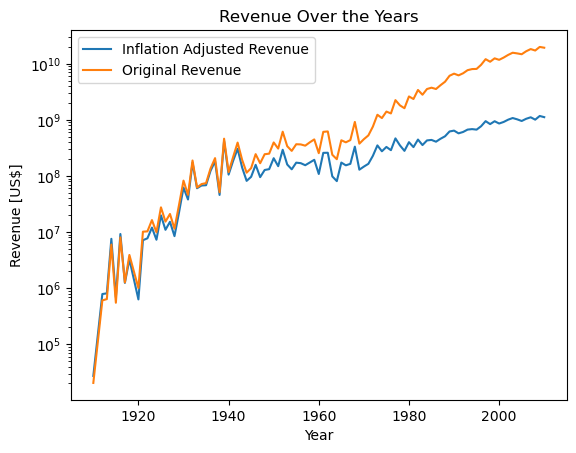

In [42]:
df_inflation = revenue_inflation_correction(movies_features_inc, inflation_raw)

# 'movies2_clean' ot whatever dataset is the right one...

In [43]:
df_inflation[df_inflation['year'] == 1915]

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination,revenue_infl
292,Kindling,1915,Kindling,6.6,31.0,14626970,/m/03gr3s9,<NA>,"[Silent film, English Language]",[USA],"[Crime Fiction, Silent film, Drama, Indie, Bla...",66036.0,NaN,False,False,0,0,82545.0
1298,The Captive,1915,The Captive,6.5,128.0,14616918,/m/03gqqyf,50.0,"[Silent film, English Language]",[USA],"[Silent film, Romance Film, Drama, Indie, Blac...",56075.0,NaN,False,False,0,0,70093.75
1851,The Warrens of Virginia,1915,The Warrens of Virginia,5.9,23.0,14616220,/m/03gqq2m,<NA>,"[Silent film, English Language]",[USA],"[Silent film, Drama, Indie, Black-and-white]",85770.0,NaN,False,False,0,0,107212.5
2484,The Arab,1915,The Arab,5.1,49.0,14617357,/m/03gqrgm,50.0,"[Silent film, English Language]",[USA],"[Silent film, Adventure, Black-and-white, Indie]",68527.0,NaN,False,False,0,0,85658.75
5464,Chimmie Fadden Out West,1915,Chimmie Fadden Out West,4.9,23.0,14627259,/m/03gr45c,50.0,"[Silent film, English Language]",[USA],"[Silent film, Western, Indie, Black-and-white,...",72036.0,NaN,False,False,0,0,90045.0
6095,Alice in Wonderland,1915,Alice in Wonderland,6.2,516.0,23669602,/m/06zr25h,52.0,[English Language],[USA],"[Silent film, Black-and-white]",97477.0,NaN,False,False,0,0,121846.25
8989,The Girl of the Golden West,1915,The Girl of the Golden West,5.4,55.0,14614654,/m/03gqn62,50.0,"[Silent film, English Language]",[USA],"[Silent film, Western, Black-and-white, Indie]",102224.0,NaN,False,False,0,0,127780.0


The very high total revenue in the year 1915 catches the eye, but the data for it is valid. In 1915 the movie "The Birth of a Nation" was released, which is a movie that was extremely succesful and had a box office revenue of about [50-100 Mio US$ (Wikipedia)](https://en.wikipedia.org/wiki/The_Birth_of_a_Nation). 

### Normalization for counterbalancing natural growth of movie industry

The steady increase in total revenue over time can be explained partly by the ever increasing number of movies released per year. One should however also consider the steady growth of the movie industry, which allows a movie to make much more revenue today (with an international distribution of the movies) as opposed to earlier in time. This effect should be taken into consideration, which is why we perform a regression analysis and normalize the data accordingly:

In [44]:
df_inflation['revenue_part'] = df_inflation.groupby('year')['revenue'].transform(lambda x: x / x.sum())
display(df_inflation.sample(5))
display(df_inflation.shape)
display(df_inflation.info())


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination,revenue_infl,revenue_part
3242,Flatland,2007,Flatland,6.8,1147.0,11716156,/m/02rpy1_,95.0,[English Language],[USA],"[Computer Animation, Science Fiction, Satire, ...",1443926.0,NaN,False,False,0,0,87723.329283,0.000079
6869,The Ultimate Warrior,1975,The Ultimate Warrior,5.6,2135.0,11273227,/m/02r5x0r,94.0,[English Language],[USA],"[Thriller, Science Fiction, Action]",10104.0,NaN,False,False,0,0,2366.276347,0.000007
4370,Alice's Restaurant,1969,Alice's Restaurant,6.2,4268.0,11357777,/m/02r8w4b,111.0,[English Language],[USA],"[Comedy-drama, Americana, Coming of age, Comedy]",10145620.0,[False],False,True,0,1,3486467.353952,0.026966
6070,The Honeymoon Killers,1970,The Honeymoon Killers,7.0,5211.0,3048488,/m/08n1b8,107.0,[English Language],[USA],"[Crime Fiction, Thriller, Biography, Crime Dra...",463814.0,NaN,False,False,0,0,150588.961039,0.001026
2770,The Sentinel,1977,The Sentinel,6.3,10462.0,2010018,/m/06dt8s,92.0,[English Language],[USA],"[Cult, Horror, Supernatural]",20910994.5,NaN,False,False,0,0,4347400.10395,0.009302


(9427, 19)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9427 entries, 0 to 9426
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            9427 non-null   object 
 1   year            9427 non-null   Int64  
 2   alt_name        9427 non-null   object 
 3   rating          9427 non-null   float64
 4   votes           9427 non-null   float64
 5   id_wiki         9427 non-null   int64  
 6   id_freebase     9427 non-null   object 
 7   runtime         9326 non-null   object 
 8   lang            9427 non-null   object 
 9   countries       9427 non-null   object 
 10  genres          9427 non-null   object 
 11  revenue         9427 non-null   object 
 12  winner          1388 non-null   object 
 13  has_won         9427 non-null   bool   
 14  nominated       9427 non-null   bool   
 15  nbr_won         9427 non-null   int64  
 16  nbr_nomination  9427 non-null   int64  
 17  revenue_infl    9427 non-null   o

None

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.505
Model:                            OLS   Adj. R-squared (uncentered):              0.500
Method:                 Least Squares   F-statistic:                              100.1
Date:                Wed, 20 Dec 2023   Prob (F-statistic):                    1.17e-16
Time:                        09:14:35   Log-Likelihood:                         -2081.4
No. Observations:                  99   AIC:                                      4165.
Df Residuals:                      98   BIC:                                      4167.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination,revenue_infl,revenue_part,revenue_norm
1196,Riot in Cell Block 11,1954,Riot in Cell Block 11,7.0,2130.0,6143584,/m/0fsf1y,80.0,[English Language],[USA],"[Drama, Prison]",4211926.5,NaN,False,False,0,0,1977430.28169,0.015063,1865785.18454
205,Selena,1997,Selena,6.8,28859.0,275547,/m/01p8m2,128.0,[English Language],[USA],"[Biographical film, Biography, Drama, Musical ...",41580763.5,NaN,False,False,0,0,3263796.193093,0.003441,3213362.310132
8185,The Mighty,1998,The Mighty,7.3,13000.0,618856,/m/02p2hxv,100.0,[English Language],[USA],"[Drama, Comedy film, Comedy-drama]",2652246.0,NaN,False,False,0,0,204964.914992,0.000244,201347.429336
7628,The Guitar,2008,The Guitar,6.4,3053.0,19965617,/m/04y866m,92.0,"[Standard Mandarin, English Language]",[USA],"[Romance Film, Musical, Drama, Indie]",19041.0,NaN,False,False,0,0,1114.160328,0.000001,1095.915627
8674,Entrapment,1999,Entrapment,6.3,115285.0,277160,/m/01pgrh,113.0,[English Language],"[USA, United Kingdom, Germany]","[Action/Adventure, Crime Thriller, Action, Cri...",165466898.0,NaN,False,False,0,0,12516406.807867,0.013246,12317817.813803


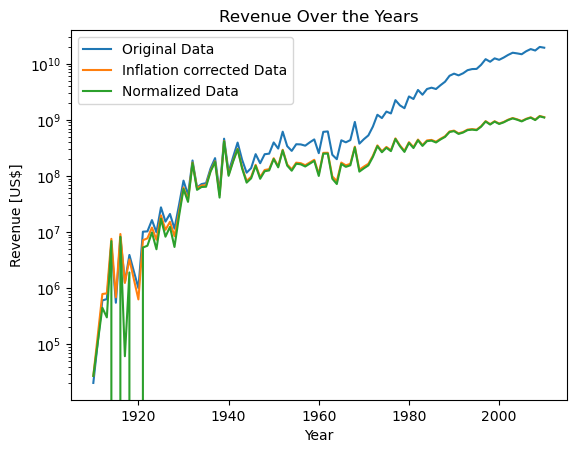

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
7895,Year of the Dragon,1985,Year of the Dragon,6.8,15851.0,1625624,/m/05hp3p,134.0,"[Standard Mandarin, Polish Language, English L...",[USA],"[Crime Fiction, Action Thrillers, Gangster Fil...",False,False,0,0,0.005871,2501060.690111
5819,Burnt Offerings,1976,Burnt Offerings,6.4,11698.0,3954720,/m/0b8g0y,114.0,[English Language],[USA],"[Horror, Haunted House Film, Film adaptation]",False,False,0,0,0.012525,3466508.951297
7172,Dirty Love,2005,Dirty Love,3.6,6800.0,3895377,/m/0b5mw7,91.0,[English Language],[USA],"[Romantic comedy, Romance Film, Sex comedy, Co...",False,False,0,0,0.000002,2284.650024
4484,The 13th Warrior,1999,The 13th Warrior,6.6,119000.0,89818,/m/0mcrb,102.0,"[Swedish Language, Latin Language, English Lan...",[USA],"[Fantasy Adventure, Action, Fantasy, Adventure]",False,False,0,0,0.004939,4593038.283671
8323,Murder Party,2007,Murder Party,5.8,11554.0,20638510,/m/052368l,80.0,[English Language],[USA],"[Cult, Black comedy, Horror, Comedy, Slasher]",False,False,0,0,0.000018,20224.566947


(9427, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9427 entries, 0 to 9426
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            9427 non-null   object 
 1   year            9427 non-null   Int64  
 2   alt_name        9427 non-null   object 
 3   rating          9427 non-null   float64
 4   votes           9427 non-null   float64
 5   id_wiki         9427 non-null   int64  
 6   id_freebase     9427 non-null   object 
 7   runtime         9326 non-null   object 
 8   lang            9427 non-null   object 
 9   countries       9427 non-null   object 
 10  genres          9427 non-null   object 
 11  has_won         9427 non-null   bool   
 12  nominated       9427 non-null   bool   
 13  nbr_won         9427 non-null   int64  
 14  nbr_nomination  9427 non-null   int64  
 15  revenue_part    9427 non-null   object 
 16  revenue_norm    9427 non-null   object 
dtypes: Int64(1), bool(2), float64(2),

None

In [45]:
movies_features = df_inflation.copy(deep=True)
movies_features = revenue_normalisation(df_inflation).drop(columns=['winner', 'revenue_infl', 'revenue'])

display(movies_features.sample(5))
display(movies_features.shape)
display(movies_features.info())


### b) Reviews

### c) Awards

### d) Plot similarity

In [46]:
movies.reset_index()

,index,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
0,0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[USA],"[Thriller, Science Fiction, Horror, Adventure,..."
1,1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[USA],"[Mystery, Biographical film, Drama, Crime Drama]"
2,5,13696889,/m/03cfc81,The Gangsters,1913,NaN,35.0,"[Silent film, English Language]",[USA],"[Short Film, Silent film, Indie, Black-and-whi..."
3,7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,[English Language],[USA],"[Musical, Comedy, Black-and-white]"
4,10,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,[English Language],[USA],"[Drama, Black-and-white]"
...,...,...,...,...,...,...,...,...,...,...
28816,74810,7761830,/m/0kvgqb,Spaced Invaders,1990,15369573.0,100.0,[English Language],[USA],"[Alien Film, Science Fiction, Family Film, Com..."
28817,74811,34474142,/m/0cpy07r,Frontier Fury,1943,NaN,55.0,[English Language],[USA],[Western]
28818,74815,1918494,/m/0660qx,State and Main,2000,6944471.0,106.0,"[Italian Language, English Language]","[France, USA]","[Parody, Americana, Comedy]"
28819,74817,24209227,/m/07k5mlk,"The Time, the Place and the Girl",1946,NaN,105.0,[English Language],[USA],"[Comedy film, Romance Film, Musical]"


In [47]:
MOVIES_PLOT = MOVIES_FOLDER + "plot_summaries.txt"
df_plot = pd.read_csv(MOVIES_PLOT, sep='\t', names=['id_wiki', 'plot'])

merged_df = df_plot.merge(movies, on='id_wiki')
merged_df.columns
corresp_table=merged_df.drop(columns=[ 'plot', 'id_freebase', 'name', 'year', 'revenue', 'runtime',
       'lang', 'countries', 'genres'])
corresp_table.head()


,id_wiki
0,2231378
1,595909
2,5272176
3,1952976
4,24225279


c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 't

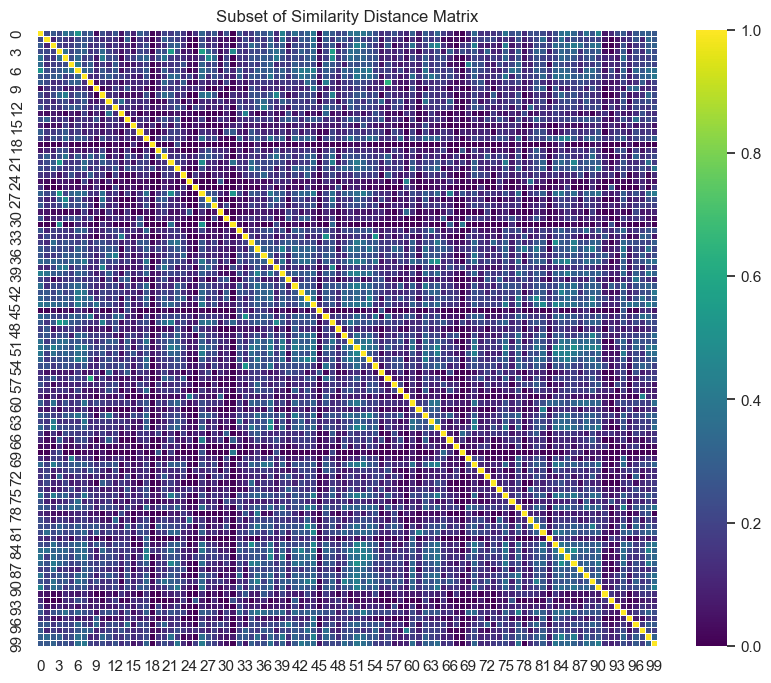

In [48]:
similarity_matrix = plot_similarity_heatmap(merged_df, 'plot')

In [49]:

# Example to find most similar movie
given_movie_index = 1665  # Replace with the index of the movie you're interested in
max_indices = np.argpartition(similarity_matrix[given_movie_index], -10)[-10:]
given_movie_name = merged_df.iloc[given_movie_index]['name']
most_similar_movie_names = merged_df.iloc[max_indices[9]]['name']

print("Given Movie Name:", given_movie_name)
print("Most Similar Movie Names:", most_similar_movie_names)
print(max_indices)

Given Movie Name: Blood of Dracula's Castle
Most Similar Movie Names: Kid Auto Races at Venice
[10055 14360   268 14623  3737 10079 14981  1665 10742  7923]


In [50]:
NAME_OF_THE_MOVIE= 'Star wars'
display( movies_features[movies_features['name'].str.contains(NAME_OF_THE_MOVIE, case=False, na=False)])


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
543,Star Wars The Clone Wars,2008,Star Wars The Clone Wars,5.9,65696.0,15726696,/m/0cpllql,90.0,[English Language],[USA],"[Thriller, Science Fiction, Adventure, Compute...",False,False,0,0,0.00401,3976617.540104
687,Star Wars Episode II Attack of the Clones,2002,Star Wars Episode II Attack of the Clones,6.6,699970.0,50957,/m/0dfw0,142.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant...",False,True,0,1,0.045113,44754347.034269
1835,Star Wars Episode VI Return of the Jedi,1983,Star Wars Episode VI Return of the Jedi,8.3,1029353.0,50744,/m/0ddjy,135.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant...",False,False,0,0,0.159098,54554885.796919
5753,Star Wars Episode I The Phantom Menace,1999,Star Wars Episode I The Phantom Menace,6.5,793302.0,50793,/m/0ddt_,136.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Adventure, ...",False,True,0,3,0.078945,73411810.245574
6420,Star Wars Episode V The Empire Strikes Back,1980,Star Wars Episode V The Empire Strikes Back,8.7,1260121.0,53964,/m/0f3m1,124.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant...",False,False,0,0,0.178028,69073715.915457
6446,The Star Wars Holiday Special,1978,The Star Wars Holiday Special,2.1,15255.0,185264,/m/0199wf,97.0,[English Language],[USA],"[Science Fiction, Adventure, Holiday Film, Ani...",False,False,0,0,0.04091,13874017.184897
7123,Star Wars Episode III Revenge of the Sith,2005,Star Wars Episode III Revenge of the Sith,7.6,777101.0,55447,/m/0fdv3,140.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Tragedy, Ad...",False,True,0,1,0.056789,53287456.278017
7796,Star Wars Revelations,2005,Star Wars Revelations,5.0,1180.0,1823554,/m/05zsyv,47.0,[English Language],[USA],"[Fan film, Indie]",False,False,0,0,0.000085,79292.884562
9319,Star Wars Episode IV A New Hope,1977,Star Wars,8.6,1339144.0,52549,/m/0dtfn,122.0,[English Language],[USA],"[Science Fiction, Adventure, Fantasy, Coming o...",True,True,6,10,0.337494,153929625.212042


In [51]:
scifi_before_star_wars = merged_df[(merged_df['genres'].apply(lambda genre : 'Science Fiction' in genre)) & (merged_df['year'] < 1977)].index
scifi_after_star_wars = merged_df[(merged_df['genres'].apply(lambda genre : 'Science Fiction' in genre)) & (merged_df['year'] > 1977)].index
comedy_df=merged_df[merged_df['genres'].apply(lambda genre : 'Science Fiction' in genre)].index

star_wars_movies = merged_df[merged_df['name'].str.contains('Star Wars', case=False, na=False)]

a=calculate_mean_similarity_1(similarity_matrix, 3769	, scifi_before_star_wars)
b=calculate_mean_similarity_1(similarity_matrix, 3769, scifi_after_star_wars)
print('Similarity means before Star Wars:{}'.format(a))
print('Similarity means after Star Wars:{}'.format(b))


Similarity means before Star Wars:0.17622116642391022
Similarity means after Star Wars:0.21030837821739862


In [52]:
import numpy as np
import pandas as pd

def find_most_influential_movie(similarity_matrix, genre, df):
    """
    Find the movie within a specific genre that has the most similarities with other movies in that genre.

    Parameters:
    - similarity_matrix (numpy.ndarray): Matrix containing pairwise similarities between movie plots.
    - genre (str): The genre for which to find the most influential movie.
    - df (pandas.DataFrame): DataFrame containing movie information, including genres.

    Returns:
    - str: The name of the most influential movie in the specified genre.
    """
    # Filter movies of the specified genre
    genre_movies = df[df['genres'].apply(lambda genres: genre in genres)]

    # Get the indices of movies of the specified genre
    genre_indices = genre_movies.index.tolist()

    # Initialize variables to store the most influential movie
    max_avg_similarity = 0.0
    most_influential_movie = None

    # Iterate through movies and compute average similarity to other movies in the genre
    for i in range(len(genre_indices)):
        avg_similarity_to_genre = np.mean(similarity_matrix[genre_indices[i], genre_indices])
        
        # Update most influential movie
        if avg_similarity_to_genre > max_avg_similarity:
            max_avg_similarity = avg_similarity_to_genre
            most_influential_movie = df.loc[genre_indices[i], 'name']

    return most_influential_movie

# Example usage:
# Assuming similarity_matrix is your pre-computed similarity matrix, and df is your DataFrame
# Replace 'Science Fiction' with the genre you are interested in
most_influential_movie = find_most_influential_movie(similarity_matrix, 'Crime Fiction', merged_df)

print(f"The most influential movie in Science Fiction is: {most_influential_movie}")


The most influential movie in Science Fiction is: I, the Jury


In [53]:
# Example usage:
# Assuming 'merged_df' is your DataFrame, 'similarity_matrix' is your pre-computed similarity matrix
movie_index = 4906  # Replace with the actual index of the film in the DataFrame
film_row = merged_df.iloc[movie_index]
genre=film_row['genres'][0]
mean_similarity_before, mean_similarity_after = calculate_mean_similarity_2(movie_index, merged_df, similarity_matrix, genre)

print(f"Mean Similarity 10 Years Before: {mean_similarity_before:.2f}")
print(f"Mean Similarity 10 Years After: {mean_similarity_after:.2f}")


Mean Similarity 10 Years Before: 0.18
Mean Similarity 10 Years After: 0.19


## 3) Method for identifying pivotal movies

### 3.1) TEST

### 3.2) Serious Buisness Machine learning

In [74]:
from helpers import *


In [69]:
# CREATION OF DF_CANDIDATES



min_elements = 3  # You can set the minimum number of elements for the if loop
result_df = process_candidates(candidates, min_elements,movies_features,merged_df,similarity_matrix)
display(result_df)

c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar 

,id_wiki,name,year,alt_name,rating,votes,genres,nbr_won,nbr_nomination,revenue_norm,trend_number,trend_genre,year_from_trend,mean_similarity_before,mean_similarity_after
0,1716921,Amazon Women on the Moon,1987,Amazon Women on the Moon,6.2,11932.0,"[Parody, Cult, Science Fiction, Comedy, Absurd...",0,0,59116.397417,1,Absurdism,3,0.160908,0.187811
1,75222,Spaceballs,1987,Spaceballs,7.1,188893.0,"[Parody, Science Fiction, Adventure, Absurdism...",0,0,4106985.482572,1,Absurdism,3,0.244459,0.303527
2,390867,UHF,1989,UHF,6.9,28522.0,"[Parody, Media Satire, Indie, Absurdism, Satir...",0,0,612316.448354,1,Absurdism,1,0.260398,0.303014
3,4727,Batman,1966,Batman,6.5,32993.0,"[Parody, Superhero movie, Camp, Action/Adventu...",0,0,149890.611723,2,Action,1,0.201120,0.179416
4,1830725,The 300 Spartans,1962,The 300 Spartans,6.5,7171.0,"[Sword and Sandal, Adventure, History, Histori...",0,0,15412724.405037,2,Action,5,0.180424,0.173512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3110,3084973,Shock Waves,1977,Shock Waves,5.5,5434.0,"[Cult, Zombie Film, Horror]",0,0,10646.326926,385,Zombie Film,3,0.104084,0.103878
3111,11696301,Deathdream,1974,Deathdream,6.6,5284.0,"[Zombie Film, Creature Film, Horror, Slasher, ...",0,0,7679.233225,385,Zombie Film,6,0.249258,0.292689
3112,1802400,Phantasm,1979,Phantasm,6.6,36816.0,"[Cult, Zombie Film, Horror, Slasher, Supernatu...",0,0,1994926.835079,385,Zombie Film,1,0.160399,0.131133
3113,1033297,Resident Evil,2002,Resident Evil,6.6,269222.0,"[Thriller, Science Fiction, Horror, Adventure,...",0,0,6865491.244426,386,Zombie Film,0,NaN,NaN


In [70]:
# FILTERING 

# Now we have the big candidates DataFrame we will Filter the non-interesting trends i.e. trends with less than 10 candidates
filtered_result_df = filter_candidates(result_df)
display(filtered_result_df)




There are 1703 different movies


,id_wiki,name,year,alt_name,rating,votes,genres,nbr_won,nbr_nomination,revenue_norm,trend_number,trend_genre,year_from_trend,mean_similarity_before,mean_similarity_after
0,1716921,Amazon Women on the Moon,1987,Amazon Women on the Moon,6.2,11932.0,"[Parody, Cult, Science Fiction, Comedy, Absurd...",0,0,59116.397417,1,Absurdism,3,0.160908,0.187811
1,75222,Spaceballs,1987,Spaceballs,7.1,188893.0,"[Parody, Science Fiction, Adventure, Absurdism...",0,0,4106985.482572,1,Absurdism,3,0.244459,0.303527
2,390867,UHF,1989,UHF,6.9,28522.0,"[Parody, Media Satire, Indie, Absurdism, Satir...",0,0,612316.448354,1,Absurdism,1,0.260398,0.303014
3,4727,Batman,1966,Batman,6.5,32993.0,"[Parody, Superhero movie, Camp, Action/Adventu...",0,0,149890.611723,2,Action,1,0.201120,0.179416
4,1830725,The 300 Spartans,1962,The 300 Spartans,6.5,7171.0,"[Sword and Sandal, Adventure, History, Histori...",0,0,15412724.405037,2,Action,5,0.180424,0.173512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3107,905906,Empire Records,1995,Empire Records,6.7,55408.0,"[Ensemble Film, Indie, Comedy-drama, Workplace...",0,0,24573.611877,382,Workplace Comedy,0,0.304628,0.303943
3109,65436,Dawn of the Dead,1978,Dawn of the Dead,7.8,119964.0,"[Horror, Indie, Doomsday film, Cult, Splatter ...",0,0,8944651.332116,385,Zombie Film,2,0.254907,0.259275
3110,3084973,Shock Waves,1977,Shock Waves,5.5,5434.0,"[Cult, Zombie Film, Horror]",0,0,10646.326926,385,Zombie Film,3,0.104084,0.103878
3111,11696301,Deathdream,1974,Deathdream,6.6,5284.0,"[Zombie Film, Creature Film, Horror, Slasher, ...",0,0,7679.233225,385,Zombie Film,6,0.249258,0.292689


In [75]:
# STANDARDIZATION

# Standardization of the features: we standardize the feature for EACH TRENDS
re = filtered_result_df.copy()
features_to_standardize = ['rating', 'nbr_won','votes', 'nbr_nomination', 'revenue_norm', 'mean_similarity_before','mean_similarity_after']
result_df_standardized = standardize_features(re, features_to_standardize)
display(result_df_standardized)

There are 1703 different movies


,trend_number,level_1,id_wiki,name,year,alt_name,rating,votes,genres,nbr_won,nbr_nomination,revenue_norm,trend_genre,year_from_trend,mean_similarity_before,mean_similarity_after
0,1,0,1716921,Amazon Women on the Moon,1987,Amazon Women on the Moon,-1.382189,-0.808505,"[Parody, Cult, Science Fiction, Comedy, Absurd...",0.000000,0.000000,-0.855815,Absurdism,3,-1.398399,-1.414203
1,1,1,75222,Spaceballs,1987,Spaceballs,0.950255,1.409111,"[Parody, Science Fiction, Adventure, Absurdism...",0.000000,0.000000,1.402939,Absurdism,3,0.516549,0.711812
2,1,2,390867,UHF,1989,UHF,0.431934,-0.600605,"[Parody, Media Satire, Indie, Absurdism, Satir...",0.000000,0.000000,-0.547124,Absurdism,1,0.881850,0.702391
3,2,3,4727,Batman,1966,Batman,-0.062406,0.427354,"[Parody, Superhero movie, Camp, Action/Adventu...",-0.249653,-0.421505,-0.832579,Action,1,0.267357,-0.054074
4,2,4,1830725,The 300 Spartans,1962,The 300 Spartans,-0.062406,-0.229093,"[Sword and Sandal, Adventure, History, Histori...",-0.249653,-0.421505,1.954462,Action,5,-0.113705,-0.166399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2597,382,3107,905906,Empire Records,1995,Empire Records,-1.297771,0.082912,"[Ensemble Film, Indie, Comedy-drama, Workplace...",0.000000,0.000000,-0.741435,Workplace Comedy,0,1.349471,1.226194
2598,385,3109,65436,Dawn of the Dead,1978,Dawn of the Dead,1.444275,1.665789,"[Horror, Indie, Doomsday film, Cult, Splatter ...",0.000000,0.000000,1.689339,Zombie Film,2,0.993219,0.774945
2599,385,3110,3084973,Shock Waves,1977,Shock Waves,-1.382816,-0.777341,"[Cult, Zombie Film, Horror]",0.000000,0.000000,-0.742915,Zombie Film,3,-1.394227,-1.150875
2600,385,3111,11696301,Deathdream,1974,Deathdream,-0.030729,-0.780541,"[Zombie Film, Creature Film, Horror, Slasher, ...",0.000000,0.000000,-0.743723,Zombie Film,6,0.903797,1.189036


In [76]:
# PIVOTAL MOVIES
STAR_WARS_IV = result_df_standardized[(result_df_standardized['id_wiki'] == 52549) & (result_df_standardized['trend_number'] == 320)].head(1)
THE_KARATE_KID = result_df_standardized[(result_df_standardized['id_wiki'] == 91133) & (result_df_standardized['trend_number'] == 247)].head(1)
TRANSFORMERS_MOVIE = result_df_standardized[(result_df_standardized['id_wiki'] == 76515) & (result_df_standardized['trend_number'] == 236)].head(1)
TOY_STORY = result_df_standardized[(result_df_standardized['id_wiki'] == 53085) & (result_df_standardized['trend_number'] == 102)].head(1)
JERRY_MAGUIRE = result_df_standardized[result_df_standardized['id_wiki'] == 142435].head(1)
WEREWOLF_IN_LONDON = result_df_standardized[result_df_standardized['id_wiki'] == 471370].head(1)
THE_LION_KING = result_df_standardized[(result_df_standardized['id_wiki'] == 88678) & (result_df_standardized['trend_number'] == 31)].head(1)
ROSEMARYS_BABY = result_df_standardized[(result_df_standardized['id_wiki'] == 9830229) & (result_df_standardized['trend_number'] == 225)].head(1)
ROCKY_HORROR_PICTURE_SHOW = result_df_standardized[(result_df_standardized['id_wiki'] == 25491) & (result_df_standardized['trend_number'] == 226)].head(1)
BEVERLY_HILLS_COP = result_df_standardized[(result_df_standardized['id_wiki'] == 680398) & (result_df_standardized['trend_number'] == 66)].head(1)

PIVOTAL=pd.concat([STAR_WARS_IV,THE_KARATE_KID,TRANSFORMERS_MOVIE,TOY_STORY,JERRY_MAGUIRE,WEREWOLF_IN_LONDON,THE_LION_KING,ROSEMARYS_BABY,ROCKY_HORROR_PICTURE_SHOW,BEVERLY_HILLS_COP])

# NON-PIVOTAL MOVIES
SCI_FI=  result_df_standardized[(result_df_standardized['id_wiki'] != 52549) & (result_df_standardized['trend_number'] == 320)]
CLOSE_ENCOUNTERS = result_df_standardized[(result_df_standardized['id_wiki'] == 146236) & (result_df_standardized['trend_number'] == 320)].head(1)
LORD_JIM = result_df_standardized[(result_df_standardized['id_wiki'] == 4693134) & (result_df_standardized['trend_number'] == 2)].head(1)
KARATE_KID_NON_PIVOTAL = result_df_standardized[(result_df_standardized['id_wiki'] == 91133) & (result_df_standardized['trend_number'] == 236)].head(1)
STAR_WARS_IV_NON_PIVOTAL = result_df_standardized[(result_df_standardized['id_wiki'] == 52549) & (result_df_standardized['trend_number'] == 100)].head(1)
THE_LION_KING_NON_PIVOTAL = result_df_standardized[(result_df_standardized['id_wiki'] == 88678) & (result_df_standardized['trend_number'] == 101)].head(1)
BEVERLY_HILLS_COP_NON_PIVOTAL = result_df_standardized[(result_df_standardized['id_wiki'] == 680398) & (result_df_standardized['trend_number'] == 368)].head(1)
THE_OCTAGON = result_df_standardized[(result_df_standardized['id_wiki'] == 9782726) & (result_df_standardized['trend_number'] == 247)].head(1)
RETURN_OF_THE_KING = result_df_standardized[(result_df_standardized['id_wiki'] == 516463) & (result_df_standardized['trend_number'] == 236)].head(1)
THE_BIRDS = result_df_standardized[(result_df_standardized['id_wiki'] == 304428) & (result_df_standardized['trend_number'] == 225)].head(1)
NON_PIVOTAL=pd.concat( [SCI_FI,CLOSE_ENCOUNTERS,LORD_JIM,KARATE_KID_NON_PIVOTAL,STAR_WARS_IV_NON_PIVOTAL,THE_LION_KING_NON_PIVOTAL,BEVERLY_HILLS_COP_NON_PIVOTAL,THE_OCTAGON,RETURN_OF_THE_KING,THE_BIRDS])
# Concatenate all DataFrames
all_movies=pd.concat([PIVOTAL,NON_PIVOTAL])

# Extract relevant features for

# Extract relevant features for training
features_train = all_movies[['rating', 'nbr_won','votes', 'nbr_nomination', 'revenue_norm', 'mean_similarity_before','mean_similarity_after','year_from_trend']]

# Create the target variable y_train (1 for pivotal movies, 0 for non-pivotal movies)
y_train = [1] * 10 + [0] * 9 + [0] *len(SCI_FI)

# Display the concatenated DataFrame
display(features_train)

# Display y_train
print(y_train)


,rating,nbr_won,votes,nbr_nomination,revenue_norm,mean_similarity_before,mean_similarity_after,year_from_trend
1917,2.086679,6.615430,6.003067,4.751050,6.572556,0.888508,0.949559,0
1522,1.655585,0.000000,3.454229,2.828427,3.794764,-0.438284,0.199747,2
1479,0.711266,0.000000,-0.031474,-0.408248,-0.354274,0.861020,1.398797,0
659,1.176986,0.000000,2.143800,2.110579,1.150586,-0.597800,0.892086,5
2019,1.235912,7.000000,3.619305,5.899142,4.172270,0.994660,0.704479,1
...,...,...,...,...,...,...,...,...
622,1.985330,2.120757,3.048746,1.819914,5.800675,0.110065,0.407813,1
2447,1.311096,-0.147643,1.307000,0.688620,7.519331,1.386656,1.438893,3
1511,-1.075141,0.000000,-0.414748,-0.353553,0.404447,0.581738,1.217496,6
1482,-0.914485,0.000000,-0.510129,-0.408248,-0.534644,-0.858895,-0.834899,6


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [77]:
# INFO FROM TRAINING

from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(solver='lbfgs')
logistic.fit(features_train,y_train)
# Print coefficients
print("Coefficients:", logistic.coef_)

# Print intercept
print("Intercept:", logistic.intercept_)

Coefficients: [[ 0.58038587  0.1301332   0.61292054  0.29796484 -0.04273978  0.08730066
   1.39826884 -0.0379788 ]]
Intercept: [-4.1156594]


In [78]:
# PREDICTION FOR EVERY TRENDS

from sklearn.linear_model import LogisticRegression

# Assuming features_train and y_train are defined
# ...

grouped_by_trend = result_df_standardized.groupby('trend_number')
# Dictionary to store most likely pivotal movie for each group
most_likely_pivotal = {}

# Iterate over groups
for trend_number, group_df in grouped_by_trend:
    # Select features and labels for the group
    features_group = group_df[['rating', 'nbr_won','votes', 'nbr_nomination', 'revenue_norm', 'mean_similarity_before','mean_similarity_after','year_from_trend']]
    
    # Predict probabilities for being pivotal
    probabilities = logistic.predict_proba(features_group)[:, 1]
    
    # Identify the index with the highest probability
    most_likely_index = probabilities.argmax()
    
    # Get the details of the most likely pivotal movie
    most_likely_movie = group_df.iloc[most_likely_index]
    
    # Store the result in the dictionary
    most_likely_pivotal[trend_number] = most_likely_movie

# Display the most likely pivotal movie for each group
for trend_number, movie_info in most_likely_pivotal.items():
    print(f"Trend {candidates[int(trend_number)][0]} of year {candidates[int(trend_number)][2]}: Most Likely Pivotal Movie - {movie_info['name']}")



Trend Absurdism of year 1990: Most Likely Pivotal Movie - Spaceballs
Trend Action of year 1967: Most Likely Pivotal Movie - Lawrence of Arabia
Trend Action Thrillers of year 1987: Most Likely Pivotal Movie - First Blood
Trend Action/Adventure of year 1966: Most Likely Pivotal Movie - Lawrence of Arabia
Trend Animal Picture of year 1992: Most Likely Pivotal Movie - Harry and the Hendersons
Trend Animation of year 1997: Most Likely Pivotal Movie - The Lion King
Trend B-movie of year 1954: Most Likely Pivotal Movie - Them!
Trend Biographical film of year 1951: Most Likely Pivotal Movie - The Desert Fox The Story of Rommel
Trend Biographical film of year 1974: Most Likely Pivotal Movie - Patton
Trend Biography of year 1970: Most Likely Pivotal Movie - Patton
Trend Biography of year 1996: Most Likely Pivotal Movie - Schindler's List
Trend Biopic [feature] of year 1951: Most Likely Pivotal Movie - Jolson Sings Again
Trend Biopic [feature] of year 1973: Most Likely Pivotal Movie - Patton
Tren

### b) (TO COMPLETE)

## 4) Analysis of the results 

We finally got the set of pivotals movies but we need to do an assessment of these results. 

### a) Convergence of the methods

### b) Correlation between pivotal movies

### c) How to make a pivotal movie ?